### Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelBinarizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import export_graphviz, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve

from subprocess import call
from IPython.display import Image
from collections import Counter
import itertools
import pydot, graphviz

### Dataset description

Data Source: https://archive.ics.uci.edu/ml/datasets/bank+marketing

**Bank client data:**
- `age`: (numeric)
- `job`: type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
- `marital`: marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
- `education`: (categorical: primary, secondary, tertiary and unknown)
- `default`: has credit in default? (categorical: 'no','yes','unknown')
- `housing`: has housing loan? (categorical: 'no','yes','unknown')- loan: has personal loan? (categorical: 'no','yes','unknown')
- `balance`: Balance of the individual.

**Related with the last contact of the current campaign:**
- `contact`: contact communication type (categorical: 'cellular','telephone')
- `month`: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
- `day`: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
- `duration`: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

**other attributes:**
- `campaign`: number of contacts performed during this campaign and for this client (numeric, includes last contact)
- `pdays`: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
- `previous`: number of contacts performed before this campaign and for this client (numeric)
- `poutcome`: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

**Output variable (desired target):**
- `y` - has the client subscribed a term deposit? (binary: 'yes','no')

### Loading Dataset

In [3]:
# Reading CSV file to load data
data = pd.read_csv("bank_marketing_compaign.csv")
data

FileNotFoundError: [Errno 2] No such file or directory: 'bank_marketing_compaign.csv'

In [ ]:
# Observing dataset's datatypes
data.info()

In [4]:
# Taking a look at quantitative values of dataset
data.describe()

age       balance           day      duration      campaign  \
count  11162.000000  11162.000000  11162.000000  11162.000000  11162.000000   
mean      41.231948   1528.538524     15.658036    371.993818      2.508421   
std       11.913369   3225.413326      8.420740    347.128386      2.722077   
min       18.000000  -6847.000000      1.000000      2.000000      1.000000   
25%       32.000000    122.000000      8.000000    138.000000      1.000000   
50%       39.000000    550.000000     15.000000    255.000000      2.000000   
75%       49.000000   1708.000000     22.000000    496.000000      3.000000   
max       95.000000  81204.000000     31.000000   3881.000000     63.000000   

              pdays      previous  
count  11162.000000  11162.000000  
mean      51.330407      0.832557  
std      108.758282      2.292007  
min       -1.000000      0.000000  
25%       -1.000000      0.000000  
50%       -1.000000      0.000000  
75%       20.750000      1.000000  
max      854.000000     58.000000

In [5]:
# Taking a look at categorical data in dataset
for col in data.select_dtypes(include=["object"]).columns:
    print(col)
    print(data[col].value_counts())
    print("-"*50)

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64
--------------------------------------------------
marital
married     6351
single      3518
divorced    1293
Name: marital, dtype: int64
--------------------------------------------------
education
secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: education, dtype: int64
--------------------------------------------------
default
no     10994
yes      168
Name: default, dtype: int64
--------------------------------------------------
housing
no     5881
yes    5281
Name: housing, dtype: int64
--------------------------------------------------
loan
no     9702
yes    1460
Name: loan, dtype: int64
--------------------------------------------------
contact
cellular     8042
u

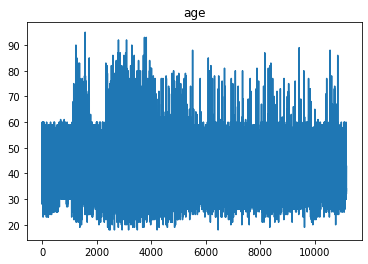

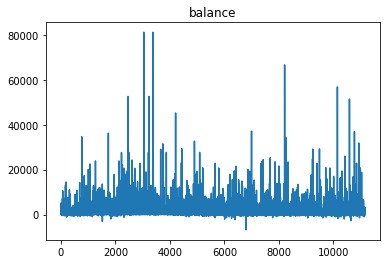

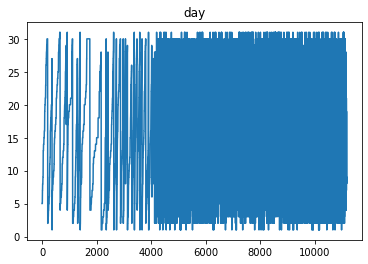

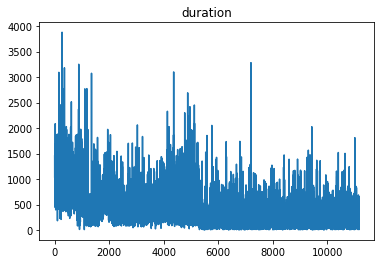

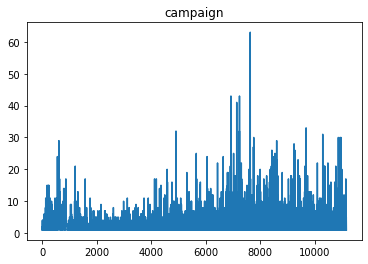

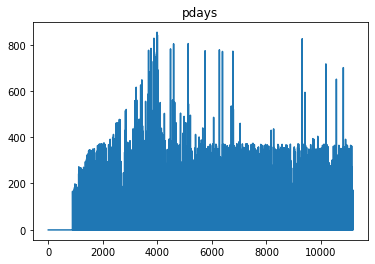

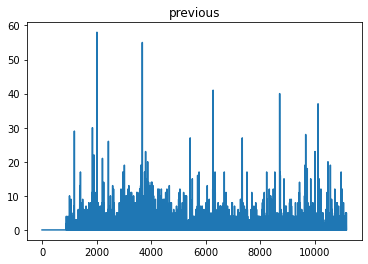

In [6]:
# Plotting a chart to see if numerical values are normally distributed or not
for ncols in data.select_dtypes(include=["int64"]).columns:
    plt.figure()
    plt.title(ncols)
    plt.plot(data[ncols])

**As observed, Data is not normally distributed, we will be using MinMaxScaler**

## Preprocessing Stage

In [282]:
# Function to plot confusion matrix
def plot_confusion_matrix(cm, title=""):
    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Oranges)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Yes','No'], rotation=45, size = 14)
    plt.yticks(tick_marks, ['Yes','No'], size = 14)

    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

In [283]:
# Handling Binary data by changing 'yes' to 1 and 'no' to 0
def handle_binary_data(data):
    if 'default' in data.columns:
        data["default"] = data['default'].replace({'yes':1, 'no':0})
    if 'housing' in data.columns:
        data["housing"] = data['housing'].replace({'yes':1, 'no':0})
    if 'loan' in data.columns:
        data["loan"] = data['loan'].replace({'yes':1, 'no':0})
    if 'deposit' in data.columns:
        data["deposit"] = data['deposit'].replace({'yes':1, 'no':0})
    return data

In [284]:
def make_xy(data):
    # Handling binary data
    data = handle_binary_data(data)
    
    # Create MinMaxScaler
    min_max_scaler = MinMaxScaler()
    num_col_list = data.select_dtypes(exclude=["object"]).columns 
    df_num = pd.DataFrame(min_max_scaler.fit_transform(data.select_dtypes(exclude=["object"])), columns=num_col_list)
    
    # OneHotEncoding
    cat_col_list = data.select_dtypes(include=["object"]).columns
    df_cat = pd.get_dummies(data.select_dtypes(include=["object"]))
    
    processed_df = pd.concat([df_cat, df_num], axis=1)
    
    # Dropping target column from main dataset
    X = processed_df.drop("deposit", axis=1)

    # Creating target column
    y = processed_df["deposit"]
    
    return X, y, X.columns

In [285]:
# Making X and y to create a split
X, y, column_list = make_xy(data)

In [286]:
# Make train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Logistic Regression

In [287]:
X_train.shape

(7813, 48)

In [12]:
#Create a Logistic Regression Object & perform Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [13]:
#Make prediction using model
y_pred = log_reg.predict(X_test)

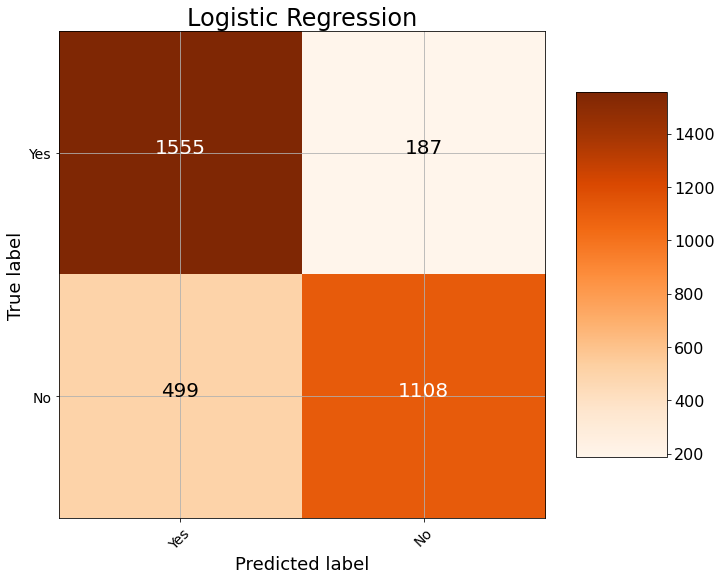

In [288]:
cf = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cf, title="Logistic Regression")

In [290]:
#Calculating Accuracy of Model using Accuracy_score method
print("Accuracy of the model using Logistic Regression: ", accuracy_score(y_test, y_pred)*100,'%')

Accuracy of the model using Logistic Regression:  79.51627351448194 %


## Using GridSearchCV to tune the hyperparameters

In [17]:
#define parameters
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [0.1, 1, 10, 100, 1000]

#define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
logreg_gscv = GridSearchCV(estimator=log_reg, param_grid=grid, n_jobs=-1, cv=cv, refit=True, verbose=True, scoring='accuracy', error_score=0)
grid_result = logreg_gscv.fit(X, y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 30 folds for each of 15 candidates, totalling 450 fits
Best: 0.825479 using {'C': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}
0.804574 (0.010323) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.804544 (0.010321) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.804544 (0.010321) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.822731 (0.011294) with: {'C': 1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.822731 (0.011318) with: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.822761 (0.011268) with: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
0.825360 (0.010139) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.825360 (0.010139) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.825360 (0.010139) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.825390 (0.010434) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.825479 (0.010440) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.825390 (0.010434) with: {'C': 100, 'penalty'

In [1]:
###### Parameter setting that gave the best results
# grid_result.best_params_
# estimator which gave highest score
# grid_result.best_estimator_

grid_predictions = grid_result.predict(X_test)
cm = confusion_matrix(y_test, grid_predictions)

plot_confusion_matrix(cm, title="Subscription to long term deposit")

# print(cm)
# print("-"*50)
print("Accuracy: ", accuracy_score(y_test, grid_predictions)*100,'%')

# print(f'Accuracy: {logreg_gscv.score(X, y):.3f}')

NameError: name 'grid_result' is not defined

In [20]:
print("Logistic Regression Accuracy: ", accuracy_score(y_test, y_pred))
print("GridSearchCV Accuracy: ", accuracy_score(y_test, grid_predictions))

Logistic Regression Accuracy:  0.820244849208719
GridSearchCV Accuracy:  0.8223350253807107


### Observation

As observed, the accuracy of Logistic Regression model is 81.81%. 

By using GridSearchCV, we were able to improve the accuracy of our model to 82.92% by changing the values of the parameters to 'C': 1000, 'penalty' : 'l2', 'solver' : 'newton-cg'

### 1. Trying to remove marital column and see the model performance

In [21]:
data_marital = data.drop('marital',axis=1)
data_marital

age          job  education  default  balance  housing  loan   contact  \
0       59       admin.  secondary        0     2343        1     0   unknown   
1       56       admin.  secondary        0       45        0     0   unknown   
2       41   technician  secondary        0     1270        1     0   unknown   
3       55     services  secondary        0     2476        1     0   unknown   
4       54       admin.   tertiary        0      184        0     0   unknown   
...    ...          ...        ...      ...      ...      ...   ...       ...   
11157   33  blue-collar    primary        0        1        1     0  cellular   
11158   39     services  secondary        0      733        0     0   unknown   
11159   32   technician  secondary        0       29        0     0  cellular   
11160   43   technician  secondary        0        0        0     1  cellular   
11161   34   technician  secondary        0        0        0     0  cellular   

       day month  duration  campaign  pdays  previous poutcome  deposit  
0        5   may      1042         1     -1         0  unknown        1  
1        5   may      1467         1     -1         0  unknown        1  
2        5   may      1389         1     -1         0  unknown        1  
3        5   may       579         1     -1         0  unknown        1  
4        5   may       673         2     -1         0  unknown        1  
...    ...   ...       ...       ...    ...       ...      ...      ...  
11157   20   apr       257         1     -1         0  unknown        0  
11158   16   jun        83         4     -1         0  unknown        0  
11159   19   aug       156         2     -1         0  unknown        0  
11160    8   may         9         2    172         5  failure        0  
11161    9   jul       628         1     -1         0  unknown        0  

[11162 rows x 16 columns]

#### Preprocessing

In [22]:
X_marital, y_marital, column_list = make_xy(data_marital)

In [23]:
# Make train and test split
X_train, X_test, y_train, y_test = train_test_split(X_marital, y_marital, test_size=0.3, random_state=42)

In [24]:
#Create a Logistic Regression Object & perform Logistic Regression
log_reg = LogisticRegression(max_iter = 1000)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [25]:
#Make prediction using model
y_pred = log_reg.predict(X_test)

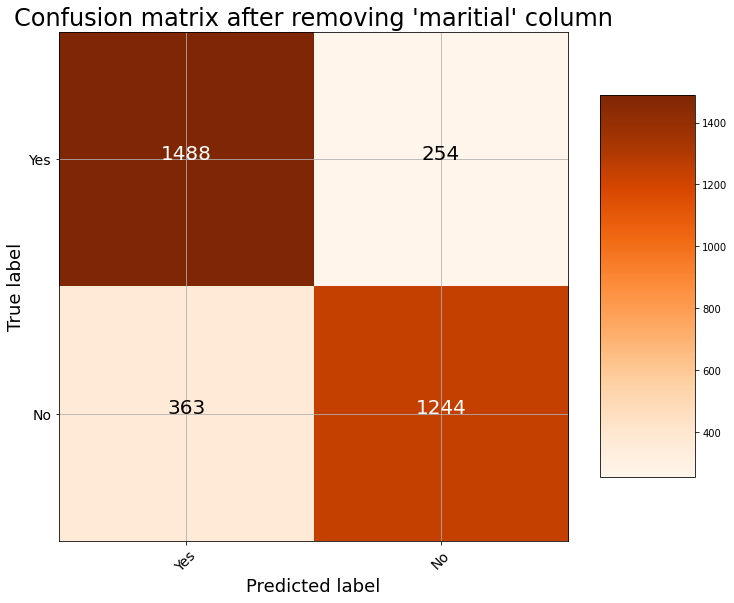

In [26]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, title="Confusion matrix after removing 'maritial' column")

In [27]:
#Calculating Accuracy of Model using Accuracy_score method
print("Accuracy of the model using Logistic Regression: ", accuracy_score(y_test, y_pred)*100,'%')

Accuracy of the model using Logistic Regression:  81.5765900268737 %


#### Observation after removing marital feature and checking

As observed, the accuracy of Logistic Regression model didn't change, so we can conclude that Marital Feature's relevance is low/null in our dataset

### 2. Trying to remove education column and see the model performance

In [28]:
data_ed = data.drop('education',axis=1)
data_ed

age          job  marital  default  balance  housing  loan   contact  \
0       59       admin.  married        0     2343        1     0   unknown   
1       56       admin.  married        0       45        0     0   unknown   
2       41   technician  married        0     1270        1     0   unknown   
3       55     services  married        0     2476        1     0   unknown   
4       54       admin.  married        0      184        0     0   unknown   
...    ...          ...      ...      ...      ...      ...   ...       ...   
11157   33  blue-collar   single        0        1        1     0  cellular   
11158   39     services  married        0      733        0     0   unknown   
11159   32   technician   single        0       29        0     0  cellular   
11160   43   technician  married        0        0        0     1  cellular   
11161   34   technician  married        0        0        0     0  cellular   

       day month  duration  campaign  pdays  previous poutcome  deposit  
0        5   may      1042         1     -1         0  unknown        1  
1        5   may      1467         1     -1         0  unknown        1  
2        5   may      1389         1     -1         0  unknown        1  
3        5   may       579         1     -1         0  unknown        1  
4        5   may       673         2     -1         0  unknown        1  
...    ...   ...       ...       ...    ...       ...      ...      ...  
11157   20   apr       257         1     -1         0  unknown        0  
11158   16   jun        83         4     -1         0  unknown        0  
11159   19   aug       156         2     -1         0  unknown        0  
11160    8   may         9         2    172         5  failure        0  
11161    9   jul       628         1     -1         0  unknown        0  

[11162 rows x 16 columns]

In [29]:
X_ed, y_ed, column_list = make_xy(data_marital)

In [30]:
# Make train and test split
X_train, X_test, y_train, y_test = train_test_split(X_ed, y_ed, test_size=0.3, random_state=42)

In [31]:
#Create a Logistic Regression Object & perform Logistic Regression
log_reg = LogisticRegression(max_iter = 1000)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [32]:
#Make prediction using model
y_pred = log_reg.predict(X_test)

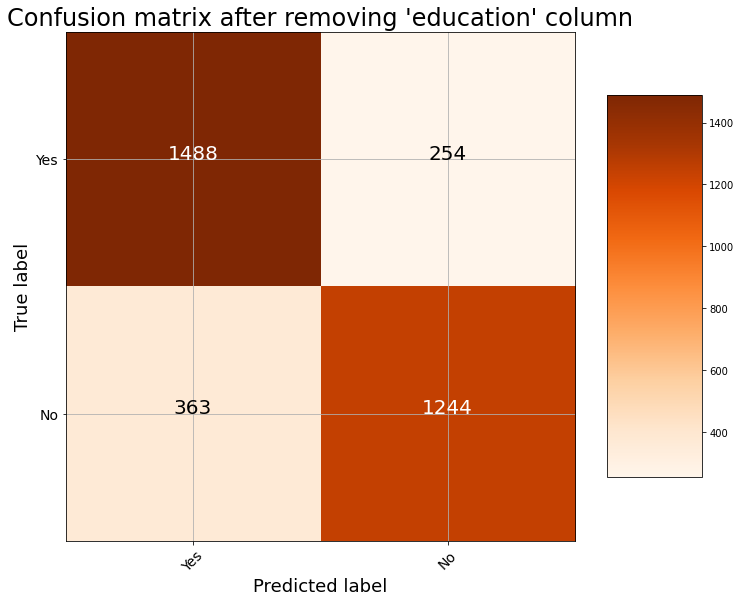

In [33]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, title="Confusion matrix after removing 'education' column")

In [34]:
#Calculating Accuracy of Model using Accuracy_score method
print("Accuracy of the model using Logistic Regression: ", accuracy_score(y_test, y_pred)*100,'%')

Accuracy of the model using Logistic Regression:  81.5765900268737 %


#### Observation after removing Education feature and checking

As observed, the accuracy of Logistic Regression model didn't change, so we can conclude that Education Feature's relevance is low/null in our dataset

### 3. Trying to remove age column and see the model performance

In [35]:
data_age = data.drop('age',axis=1)
data_age

job  marital  education  default  balance  housing  loan  \
0           admin.  married  secondary        0     2343        1     0   
1           admin.  married  secondary        0       45        0     0   
2       technician  married  secondary        0     1270        1     0   
3         services  married  secondary        0     2476        1     0   
4           admin.  married   tertiary        0      184        0     0   
...            ...      ...        ...      ...      ...      ...   ...   
11157  blue-collar   single    primary        0        1        1     0   
11158     services  married  secondary        0      733        0     0   
11159   technician   single  secondary        0       29        0     0   
11160   technician  married  secondary        0        0        0     1   
11161   technician  married  secondary        0        0        0     0   

        contact  day month  duration  campaign  pdays  previous poutcome  \
0       unknown    5   may      1042         1     -1         0  unknown   
1       unknown    5   may      1467         1     -1         0  unknown   
2       unknown    5   may      1389         1     -1         0  unknown   
3       unknown    5   may       579         1     -1         0  unknown   
4       unknown    5   may       673         2     -1         0  unknown   
...         ...  ...   ...       ...       ...    ...       ...      ...   
11157  cellular   20   apr       257         1     -1         0  unknown   
11158   unknown   16   jun        83         4     -1         0  unknown   
11159  cellular   19   aug       156         2     -1         0  unknown   
11160  cellular    8   may         9         2    172         5  failure   
11161  cellular    9   jul       628         1     -1         0  unknown   

       deposit  
0            1  
1            1  
2            1  
3            1  
4            1  
...        ...  
11157        0  
11158        0  
11159        0  
11160        0  
11161        0  

[11162 rows x 16 columns]

In [36]:
X_age, y_age, column_list = make_xy(data_age)

In [37]:
# Make train and test split
X_train, X_test, y_train, y_test = train_test_split(X_age, y_age, test_size=0.3, random_state=42)

In [38]:
#Create a Logistic Regression Object & perform Logistic Regression
log_reg = LogisticRegression(max_iter = 1000)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [39]:
#Make prediction using model
y_pred = log_reg.predict(X_test)

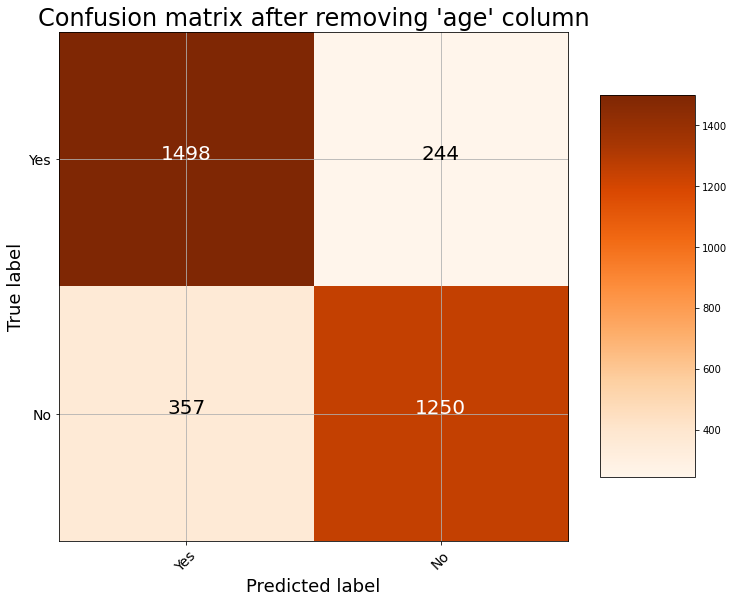

In [40]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, title="Confusion matrix after removing 'age' column")

In [41]:
#Calculating Accuracy of Model using Accuracy_score method
print("Accuracy of the model using Logistic Regression: ", accuracy_score(y_test, y_pred)*100,'%')

Accuracy of the model using Logistic Regression:  82.05434458047178 %


#### Observation after removing age feature and checking

As observed, the accuracy of Logistic Regression model increased to 81.87% from 81.81%, so we can conclude that Age Feature is relevant in our dataset

### 4. Trying to remove duration column and see the model performance

In [42]:
data_duration = data.drop('duration',axis=1)
data_duration

age          job  marital  education  default  balance  housing  loan  \
0       59       admin.  married  secondary        0     2343        1     0   
1       56       admin.  married  secondary        0       45        0     0   
2       41   technician  married  secondary        0     1270        1     0   
3       55     services  married  secondary        0     2476        1     0   
4       54       admin.  married   tertiary        0      184        0     0   
...    ...          ...      ...        ...      ...      ...      ...   ...   
11157   33  blue-collar   single    primary        0        1        1     0   
11158   39     services  married  secondary        0      733        0     0   
11159   32   technician   single  secondary        0       29        0     0   
11160   43   technician  married  secondary        0        0        0     1   
11161   34   technician  married  secondary        0        0        0     0   

        contact  day month  campaign  pdays  previous poutcome  deposit  
0       unknown    5   may         1     -1         0  unknown        1  
1       unknown    5   may         1     -1         0  unknown        1  
2       unknown    5   may         1     -1         0  unknown        1  
3       unknown    5   may         1     -1         0  unknown        1  
4       unknown    5   may         2     -1         0  unknown        1  
...         ...  ...   ...       ...    ...       ...      ...      ...  
11157  cellular   20   apr         1     -1         0  unknown        0  
11158   unknown   16   jun         4     -1         0  unknown        0  
11159  cellular   19   aug         2     -1         0  unknown        0  
11160  cellular    8   may         2    172         5  failure        0  
11161  cellular    9   jul         1     -1         0  unknown        0  

[11162 rows x 16 columns]

In [43]:
X_duration, y_duration, column_list = make_xy(data_duration)

In [44]:
# Make train and test split
X_train, X_test, y_train, y_test = train_test_split(X_duration, y_duration, test_size=0.3, random_state=42)

In [45]:
#Create a Logistic Regression Object & perform Logistic Regression
log_reg = LogisticRegression(max_iter = 1000)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [46]:
#Make prediction using model
y_pred = log_reg.predict(X_test)

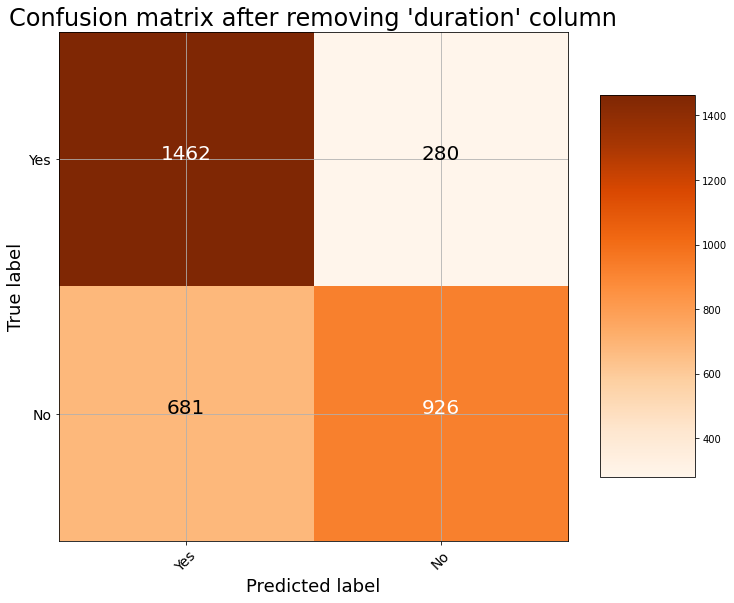

In [47]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, title="Confusion matrix after removing 'duration' column")

In [48]:
#Calculating Accuracy of Model using Accuracy_score method
print("Accuracy of the model using Logistic Regression: ", accuracy_score(y_test, y_pred)*100,'%')

Accuracy of the model using Logistic Regression:  71.30486712451479 %


#### Observation after removing duration feature and checking

As observed, the accuracy of Logistic Regression model decreased to 70.46% from 81.81%, so we can conclude that Duration Feature(last contact duration) is highly relevant in our dataset

### 5. Trying to remove balance column and see the model performance

In [49]:
data_balance = data.drop('balance',axis=1)
data_balance

age          job  marital  education  default  housing  loan   contact  \
0       59       admin.  married  secondary        0        1     0   unknown   
1       56       admin.  married  secondary        0        0     0   unknown   
2       41   technician  married  secondary        0        1     0   unknown   
3       55     services  married  secondary        0        1     0   unknown   
4       54       admin.  married   tertiary        0        0     0   unknown   
...    ...          ...      ...        ...      ...      ...   ...       ...   
11157   33  blue-collar   single    primary        0        1     0  cellular   
11158   39     services  married  secondary        0        0     0   unknown   
11159   32   technician   single  secondary        0        0     0  cellular   
11160   43   technician  married  secondary        0        0     1  cellular   
11161   34   technician  married  secondary        0        0     0  cellular   

       day month  duration  campaign  pdays  previous poutcome  deposit  
0        5   may      1042         1     -1         0  unknown        1  
1        5   may      1467         1     -1         0  unknown        1  
2        5   may      1389         1     -1         0  unknown        1  
3        5   may       579         1     -1         0  unknown        1  
4        5   may       673         2     -1         0  unknown        1  
...    ...   ...       ...       ...    ...       ...      ...      ...  
11157   20   apr       257         1     -1         0  unknown        0  
11158   16   jun        83         4     -1         0  unknown        0  
11159   19   aug       156         2     -1         0  unknown        0  
11160    8   may         9         2    172         5  failure        0  
11161    9   jul       628         1     -1         0  unknown        0  

[11162 rows x 16 columns]

In [50]:
X_balance, y_balance, column_list = make_xy(data_balance)

In [51]:
# Make train and test split
X_train, X_test, y_train, y_test = train_test_split(X_balance, y_balance, test_size=0.3, random_state=42)

In [52]:
#Create a Logistic Regression Object & perform Logistic Regression
log_reg = LogisticRegression(max_iter = 1000)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [53]:
#Make prediction using model
y_pred = log_reg.predict(X_test)

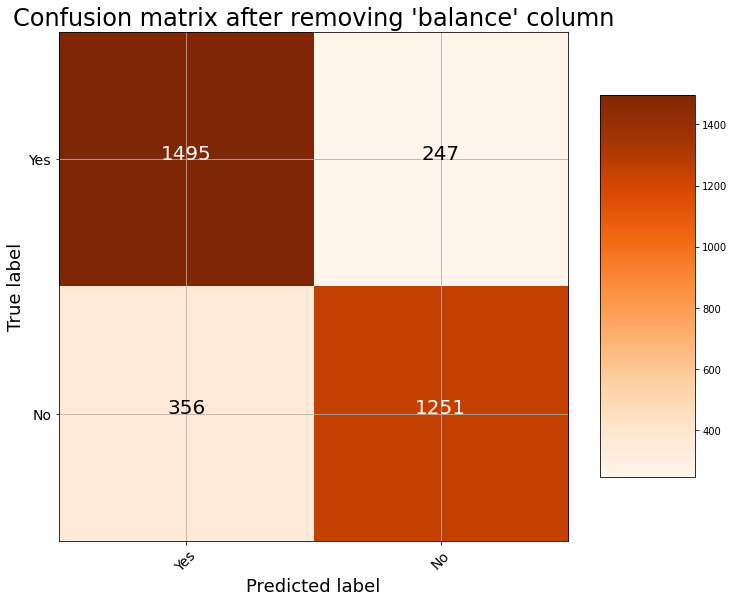

In [54]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, title="Confusion matrix after removing 'balance' column")

In [55]:
#Calculating Accuracy of Model using Accuracy_score method
print("Accuracy of the model using Logistic Regression: ", accuracy_score(y_test, y_pred)*100,'%')

Accuracy of the model using Logistic Regression:  81.99462526127202 %


#### Observation after removing balance feature and checking

As observed, the accuracy of Logistic Regression model decreased to 81.75% from 81.81%, so we can conclude that Balance Feature is relevant in our dataset

# Decision Tree

In [56]:
RSEED = 5
tree = DecisionTreeClassifier(random_state=RSEED)

In [57]:
tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=5)

In [58]:
print(f'Decision tree has {tree.tree_.node_count} nodes with maximum depth {tree.tree_.max_depth}.')

Decision tree has 2331 nodes with maximum depth 30.


In [59]:
# Make probability predictions
probs = tree.predict_proba(X_test)[:, 1]

predictions = tree.predict(X_test)

In [60]:
print(f'Test ROC AUC  Score: {roc_auc_score(y_test, probs)}')

print(f'Baseline ROC AUC: {roc_auc_score(y_test, [1 for _ in range(len(y_test))])}')

Test ROC AUC  Score: 0.7923402350651605
Baseline ROC AUC: 0.5


In [61]:
def evaluate_model(predictions, probs, train_predictions, train_probs, test_labels, train_labels):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['precision'] = precision_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(test_labels, predictions)
    results['precision'] = precision_score(test_labels, predictions)
    results['roc'] = roc_auc_score(test_labels, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(train_labels, train_predictions)
    train_results['precision'] = precision_score(train_labels, train_predictions)
    train_results['roc'] = roc_auc_score(train_labels, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
    model_fpr, model_tpr, _ = roc_curve(test_labels, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');


Recall Baseline: 1.0 Test: 0.78 Train: 1.0
Precision Baseline: 0.48 Test: 0.79 Train: 1.0
Roc Baseline: 0.5 Test: 0.79 Train: 1.0


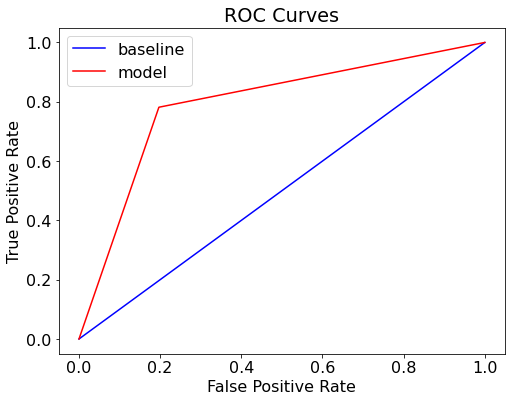

In [62]:
train_probs = tree.predict_proba(X_train)[:, 1]
train_predictions = tree.predict(X_train)

evaluate_model(predictions, probs, train_predictions, train_probs, y_test, y_train)

In [63]:
print(f"Accuracy of Decision Tree model is: {accuracy_score(y_test, predictions)*100}%")

Accuracy of Decision Tree model is: 79.2773962376829%


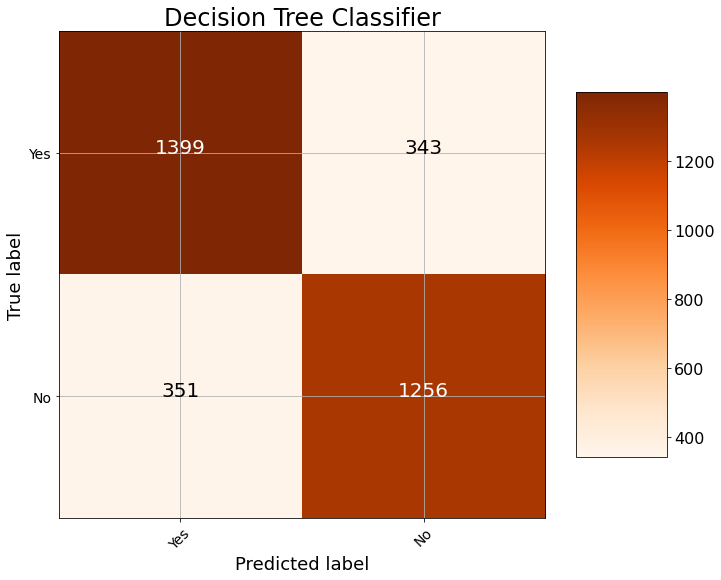

In [64]:
cm = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cm, title="Decision Tree Classifier")

In [65]:
fi = pd.DataFrame({'feature': column_list,
                   'importance': tree.feature_importances_}).sort_values('importance', ascending = False)
fi.head()

feature  importance
43          duration    0.360779
42               day    0.087734
36  poutcome_success    0.079873
38               age    0.072437
21   contact_unknown    0.062452

## Decision Tree Representation

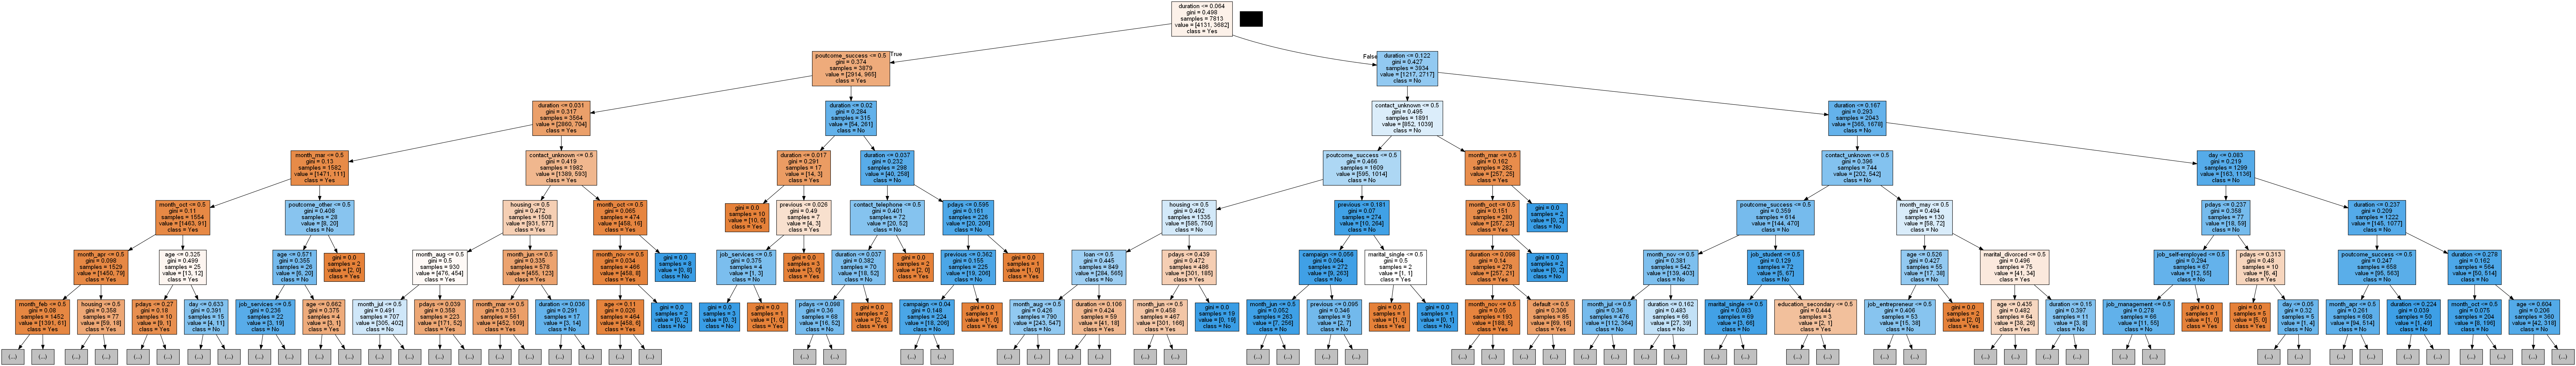

In [66]:
#dotfile = open('tree_real_data.png', 'w')
export_graphviz(tree, out_file = 'tree_real_data1.dot', 
                feature_names = column_list, max_depth = 3,
                class_names = ['Yes', 'No'], filled = True)
#dotfile.close()

(graph,) = pydot.graph_from_dot_file('tree_real_data1.dot')
graph.write_png('tree_real_data1.png')

# Visualize
Image(filename='somefile.png')

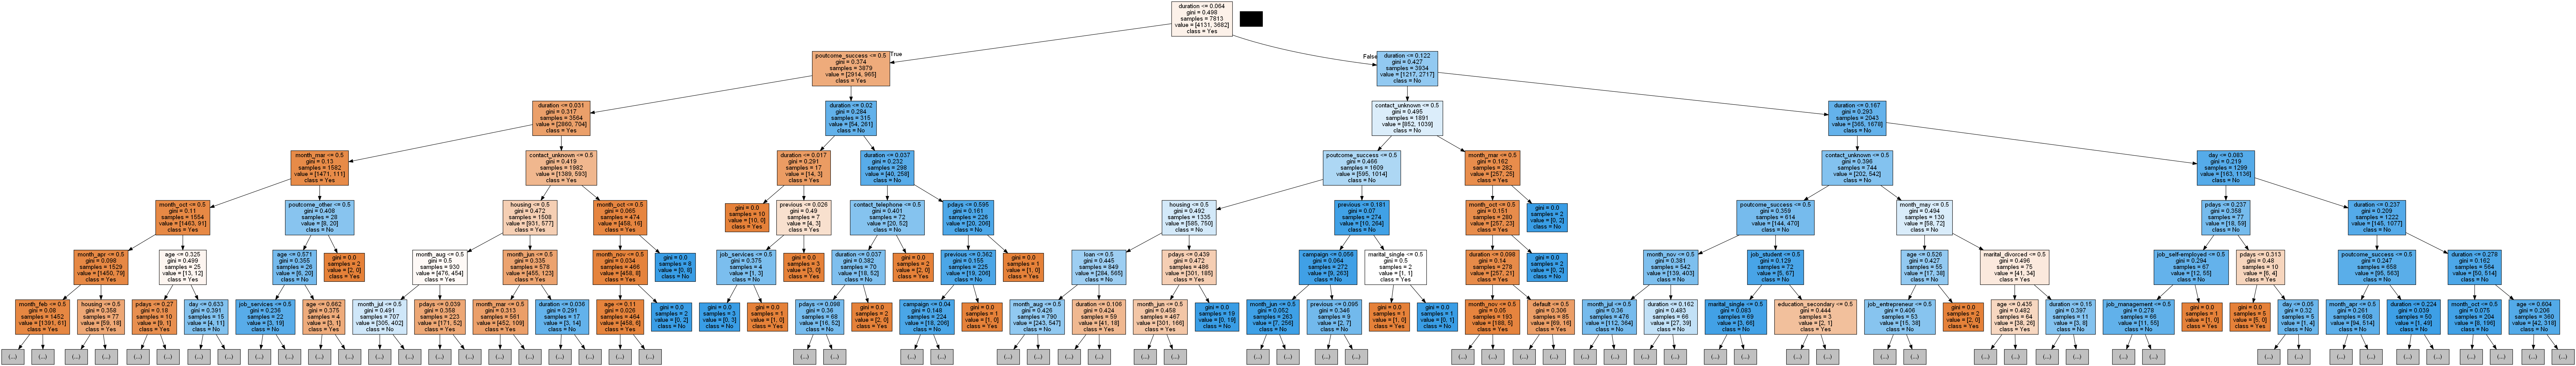

In [67]:
#dotfile = open('tree_real_data.png', 'w')
export_graphviz(tree, out_file = 'tree_real_data1.dot', 
                feature_names = column_list, max_depth = 6,
                class_names = ['Yes', 'No'], filled = True)
#dotfile.close()

(graph,) = pydot.graph_from_dot_file('tree_real_data1.dot')
graph.write_png('somefile.png')

# Visualize
Image(filename='somefile.png')

## Using GridSearchCV

In [68]:
param_grid = {'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]}

In [69]:
grid_decisiontree = GridSearchCV(DecisionTreeClassifier(), param_grid, cv = 5)
grid_decisiontree.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30,
                                       40, 50, 70, 90, 120, 150]})

In [70]:
grid_decisiontree.best_params_

{'criterion': 'entropy', 'max_depth': 12}

In [71]:
grid_decisiontree.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=12)

In [72]:
grid_decisiontree_predictions = grid_decisiontree.predict(X_test)

In [73]:
grid_decisiontree_cf = confusion_matrix(y_test, grid_decisiontree_predictions)
grid_decisiontree_cf

array([[1402,  340],
       [ 251, 1356]], dtype=int64)

In [74]:
#Accuracy of the optimised dt
print(f"Accuracy: {accuracy_score(y_test, grid_decisiontree_predictions)*100}%")

Accuracy: 82.35294117647058%


In [75]:
#Comparing the accuracies 
print(f"Decision Tree Accuracy: {accuracy_score(y_test, probs)*100}%")
print(f"GridSearchCV accuracy: {accuracy_score(y_test, grid_decisiontree_predictions)*100}%")

Decision Tree Accuracy: 79.2773962376829%
GridSearchCV accuracy: 82.35294117647058%


### Observation
By using GridSearchCV we were able to improve the accuracy of our Decision tress classifier from 78.62% to 82.44%.

The optimised classifier is decision tree({'criterion': 'gini', 'max_depth': 10})

## 1. Checking the performace after removing duration column

In [76]:
data_duration_remove = data.drop('duration', axis=1)
data_duration_remove.head()

age         job  marital  education  default  balance  housing  loan  \
0   59      admin.  married  secondary        0     2343        1     0   
1   56      admin.  married  secondary        0       45        0     0   
2   41  technician  married  secondary        0     1270        1     0   
3   55    services  married  secondary        0     2476        1     0   
4   54      admin.  married   tertiary        0      184        0     0   

   contact  day month  campaign  pdays  previous poutcome  deposit  
0  unknown    5   may         1     -1         0  unknown        1  
1  unknown    5   may         1     -1         0  unknown        1  
2  unknown    5   may         1     -1         0  unknown        1  
3  unknown    5   may         1     -1         0  unknown        1  
4  unknown    5   may         2     -1         0  unknown        1

In [77]:
X_duration, y_duration, columns_list = make_xy(data_duration_remove)

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X_duration, y_duration, test_size=0.3, random_state=42)

In [79]:
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [80]:
# Make probability predictions
probs = tree.predict_proba(X_test)[:, 1]

predictions = tree.predict(X_test)

print(f'Test ROC AUC  Score: {roc_auc_score(y_test, probs)}')

print(f'Baseline ROC AUC: {roc_auc_score(y_test, [1 for _ in range(len(y_test))])}')

Test ROC AUC  Score: 0.6415567083447345
Baseline ROC AUC: 0.5


In [81]:
print(f"Accuracy of Decision Tree model is: {accuracy_score(y_test, predictions)*100}%")

Accuracy of Decision Tree model is: 64.1982681397432%


In [82]:
fi = pd.DataFrame({'feature': columns_list,
                   'importance': tree.feature_importances_}).sort_values('importance', ascending = False)
fi.head()

feature  importance
40           balance    0.183094
43               day    0.127208
38               age    0.122775
36  poutcome_success    0.078646
44          campaign    0.062562

### Observation

The accuracy of the model reduces from 78.62% to 64.19% after removing the duration column. Hence, concluding that the feature is highly relevant to our dataset.

## 2. Checking the performace after removing job column

In [83]:
data_job_remove = data.drop('job', axis=1)
data_job_remove.head()

age  marital  education  default  balance  housing  loan  contact  day  \
0   59  married  secondary        0     2343        1     0  unknown    5   
1   56  married  secondary        0       45        0     0  unknown    5   
2   41  married  secondary        0     1270        1     0  unknown    5   
3   55  married  secondary        0     2476        1     0  unknown    5   
4   54  married   tertiary        0      184        0     0  unknown    5   

  month  duration  campaign  pdays  previous poutcome  deposit  
0   may      1042         1     -1         0  unknown        1  
1   may      1467         1     -1         0  unknown        1  
2   may      1389         1     -1         0  unknown        1  
3   may       579         1     -1         0  unknown        1  
4   may       673         2     -1         0  unknown        1

In [84]:
X_job, y_job, columns_list = make_xy(data_job_remove)

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X_job, y_job, test_size=0.3, random_state=42)

In [86]:
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [87]:
# Make probability predictions
probs = tree.predict_proba(X_test)[:, 1]

predictions = tree.predict(X_test)

print(f'Test ROC AUC  Score: {roc_auc_score(y_test, probs)}')

print(f'Baseline ROC AUC: {roc_auc_score(y_test, [1 for _ in range(len(y_test))])}')

Test ROC AUC  Score: 0.7882230939982011
Baseline ROC AUC: 0.5


In [88]:
print(f"Accuracy of Decision Tree model is: {accuracy_score(y_test, predictions)*100}%")

Accuracy of Decision Tree model is: 78.88922066288444%


In [89]:
fi = pd.DataFrame({'feature': columns_list,
                   'importance': tree.feature_importances_}).sort_values('importance', ascending = False)
fi.head()

feature  importance
32          duration    0.351397
24  poutcome_success    0.079443
31               day    0.078890
28           balance    0.077155
26               age    0.068691

### Observation

The accuracy of the model increases from 78.62% to 78.88% after removing the job column. Hence, concluding that the feature is slightly relevant to our dataset.

## 3. Checking the performace after removing balance column

In [90]:
data_balance_remove = data.drop('balance', axis=1)
data_balance_remove.head()

age         job  marital  education  default  housing  loan  contact  day  \
0   59      admin.  married  secondary        0        1     0  unknown    5   
1   56      admin.  married  secondary        0        0     0  unknown    5   
2   41  technician  married  secondary        0        1     0  unknown    5   
3   55    services  married  secondary        0        1     0  unknown    5   
4   54      admin.  married   tertiary        0        0     0  unknown    5   

  month  duration  campaign  pdays  previous poutcome  deposit  
0   may      1042         1     -1         0  unknown        1  
1   may      1467         1     -1         0  unknown        1  
2   may      1389         1     -1         0  unknown        1  
3   may       579         1     -1         0  unknown        1  
4   may       673         2     -1         0  unknown        1

In [91]:
X_balance, y_balance, columns_list = make_xy(data_balance_remove)

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X_balance, y_balance, test_size=0.3, random_state=42)

In [93]:
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [94]:
# Make probability predictions
probs = tree.predict_proba(X_test)[:, 1]

predictions = tree.predict(X_test)

print(f'Test ROC AUC  Score: {roc_auc_score(y_test, probs)}')

print(f'Baseline ROC AUC: {roc_auc_score(y_test, [1 for _ in range(len(y_test))])}')

Test ROC AUC  Score: 0.7981554222092353
Baseline ROC AUC: 0.5


In [95]:
print(f"Accuracy of Decision Tree model is: {accuracy_score(y_test, predictions)*100}%")

Accuracy of Decision Tree model is: 79.84472977008062%


In [96]:
fi = pd.DataFrame({'feature': columns_list,
                   'importance': tree.feature_importances_}).sort_values('importance', ascending = False)
fi.head()

feature  importance
43          duration    0.360701
42               day    0.089700
36  poutcome_success    0.079616
38               age    0.069165
21   contact_unknown    0.061293

### Observation

The accuracy of the model increases from 78.62% to 79.84% after removing the balance column. Hence, we can conclude that the feature is relevant to our dataset.

## 4. Checking the performace after removing balance, age, and default columns

In [100]:
data_balance_age_default_remove = data.drop(['balance', 'age','default'], axis=1)
data_balance_age_default_remove.head()

job  marital  education  housing  loan  contact  day month  \
0      admin.  married  secondary        1     0  unknown    5   may   
1      admin.  married  secondary        0     0  unknown    5   may   
2  technician  married  secondary        1     0  unknown    5   may   
3    services  married  secondary        1     0  unknown    5   may   
4      admin.  married   tertiary        0     0  unknown    5   may   

   duration  campaign  pdays  previous poutcome  deposit  
0      1042         1     -1         0  unknown        1  
1      1467         1     -1         0  unknown        1  
2      1389         1     -1         0  unknown        1  
3       579         1     -1         0  unknown        1  
4       673         2     -1         0  unknown        1

In [102]:
X_balance_age_default, y_balance_age_default, columns_list = make_xy(data_balance_age_default_remove)

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X_balance_age_default, y_balance_age_default, test_size=0.3, random_state=42)

In [104]:
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [105]:
# Make probability predictions
probs = tree.predict_proba(X_test)[:, 1]

predictions = tree.predict(X_test)

print(f'Test ROC AUC  Score: {roc_auc_score(y_test, probs)}')

print(f'Baseline ROC AUC: {roc_auc_score(y_test, [1 for _ in range(len(y_test))])}')

Test ROC AUC  Score: 0.8008109969514831
Baseline ROC AUC: 0.5


In [106]:
print(f"Accuracy of Decision Tree model is: {accuracy_score(y_test, predictions)*100}%")

Accuracy of Decision Tree model is: 80.11346670647954%


In [107]:
fi = pd.DataFrame({'feature': columns_list,
                   'importance': tree.feature_importances_}).sort_values('importance', ascending = False)
fi.head()

feature  importance
41          duration    0.380173
40               day    0.096613
36  poutcome_success    0.079616
21   contact_unknown    0.062576
43             pdays    0.039894

### Observation

The accuracy of the model increases from 78.62% to 80.11% after removing the balance column. Hence, we can conclude that the features are highly relevant to our dataset.

## 5. Checking the performace after removing month column

In [108]:
data_month_remove = data.drop(['month'], axis=1)
data_month_remove.head()

age         job  marital  education  default  balance  housing  loan  \
0   59      admin.  married  secondary        0     2343        1     0   
1   56      admin.  married  secondary        0       45        0     0   
2   41  technician  married  secondary        0     1270        1     0   
3   55    services  married  secondary        0     2476        1     0   
4   54      admin.  married   tertiary        0      184        0     0   

   contact  day  duration  campaign  pdays  previous poutcome  deposit  
0  unknown    5      1042         1     -1         0  unknown        1  
1  unknown    5      1467         1     -1         0  unknown        1  
2  unknown    5      1389         1     -1         0  unknown        1  
3  unknown    5       579         1     -1         0  unknown        1  
4  unknown    5       673         2     -1         0  unknown        1

In [109]:
X_month, y_month, columns_list = make_xy(data_month_remove)

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X_month, y_month, test_size=0.3, random_state=42)

In [111]:
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [112]:
# Make probability predictions
probs = tree.predict_proba(X_test)[:, 1]

predictions = tree.predict(X_test)

print(f'Test ROC AUC  Score: {roc_auc_score(y_test, probs)}')

print(f'Baseline ROC AUC: {roc_auc_score(y_test, [1 for _ in range(len(y_test))])}')

Test ROC AUC  Score: 0.742398533396871
Baseline ROC AUC: 0.5


In [113]:
print(f"Accuracy of Decision Tree model is: {accuracy_score(y_test, predictions)*100}%")

Accuracy of Decision Tree model is: 74.38041206330249%


In [114]:
fi = pd.DataFrame({'feature': columns_list,
                   'importance': tree.feature_importances_}).sort_values('importance', ascending = False)
fi.head()

feature  importance
32          duration    0.370050
28           balance    0.092051
26               age    0.086448
24  poutcome_success    0.079186
31               day    0.073966

### Observation

The accuracy of the model reduces from 78.62% to 74.38% after removing the balance column. Hence, we can conclude that the features are highly relevant to our dataset.

In [115]:
#dotfile = open('tree_real_data.png', 'w')
export_graphviz(tree, out_file = 'tree_real_data1.dot', 
                feature_names = columns_list, max_depth = 10,
                class_names = ['Yes', 'No'], filled = True)
#dotfile.close()

(graph,) = pydot.graph_from_dot_file('tree_real_data1.dot')
graph.write_png('tree_real_data1.png')

# Visualize
Image(filename='tree_real_data1.png')

# Random Forest

In [118]:
# Creating and Implementing Random Forest Classifier
rf_model = RandomForestClassifier()
rf_model.fit(X_train , y_train)

RandomForestClassifier()

In [119]:
#Prediction using Random Forest Classifier
y_pred_rf = rf_model.predict(X_test)

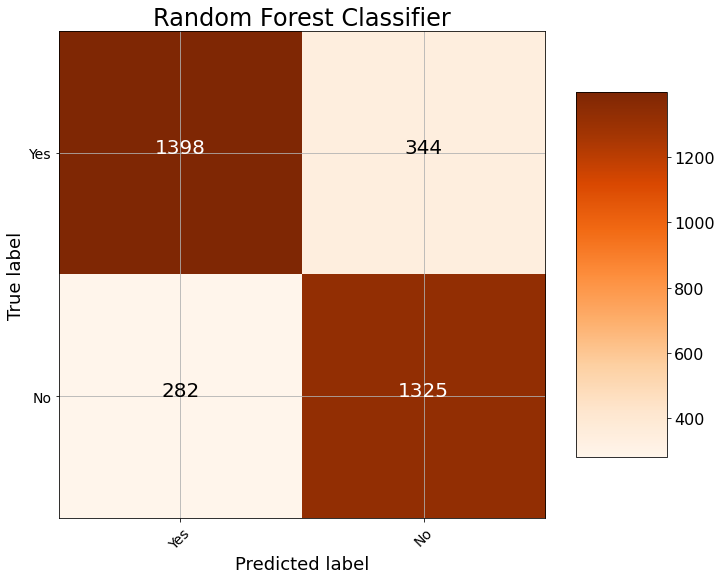

In [122]:
cf = confusion_matrix(y_test, y_pred_rf)
plot_confusion_matrix(cf, title="Random Forest Classifier")

In [124]:
#Calculating Accuracy of Model using Accuracy_score method
print("Accuracy of the model using Random Forest Algorithm: ", accuracy_score(y_test, y_pred_rf)*100,'%')

Accuracy of the model using Random Forest Algorithm:  81.30785309047477 %


## Using GridSearchCV to tune the hyperparameters

In [125]:
#define parameters
n_estimators = [5,10,20,50,100]
criterion = ['gini','entropy', 'log_loss']

#define grid search
grid = dict(n_estimators=n_estimators,criterion=criterion)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
rfmodel_gscv = GridSearchCV(estimator=rf_model, param_grid=grid, cv=cv, n_jobs=-1, refit=True, verbose=True, scoring='accuracy', error_score=0)
# grid_result_rf = rfmodel_gscv.fit(X, y)
grid_result_rf = rfmodel_gscv.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result_rf.best_score_, grid_result_rf.best_params_))
means = grid_result_rf.cv_results_['mean_test_score']
stds = grid_result_rf.cv_results_['std_test_score']
params = grid_result_rf.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("Accuracy: %f with: %r" % (mean, param))

Fitting 30 folds for each of 15 candidates, totalling 450 fits
Best: 0.826912 using {'criterion': 'log_loss', 'n_estimators': 100}
Accuracy: 0.788813 with: {'criterion': 'gini', 'n_estimators': 5}
Accuracy: 0.802978 with: {'criterion': 'gini', 'n_estimators': 10}
Accuracy: 0.814710 with: {'criterion': 'gini', 'n_estimators': 20}
Accuracy: 0.823541 with: {'criterion': 'gini', 'n_estimators': 50}
Accuracy: 0.826741 with: {'criterion': 'gini', 'n_estimators': 100}
Accuracy: 0.797899 with: {'criterion': 'entropy', 'n_estimators': 5}
Accuracy: 0.804855 with: {'criterion': 'entropy', 'n_estimators': 10}
Accuracy: 0.818634 with: {'criterion': 'entropy', 'n_estimators': 20}
Accuracy: 0.826358 with: {'criterion': 'entropy', 'n_estimators': 50}
Accuracy: 0.826357 with: {'criterion': 'entropy', 'n_estimators': 100}
Accuracy: 0.793806 with: {'criterion': 'log_loss', 'n_estimators': 5}
Accuracy: 0.804470 with: {'criterion': 'log_loss', 'n_estimators': 10}
Accuracy: 0.819871 with: {'criterion': 'log

{'criterion': 'log_loss', 'n_estimators': 100}
Accuracy:  81.33771275007466 %


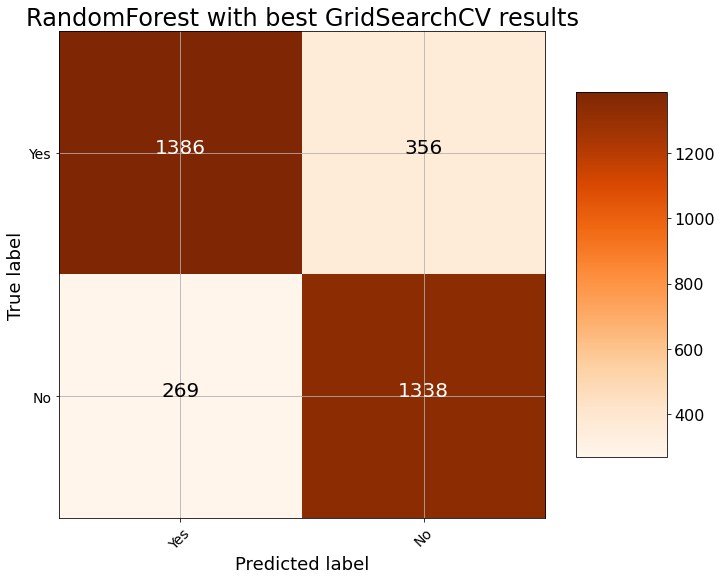

In [126]:
# Parameter setting that gave the best results
print(grid_result_rf.best_params_)
# estimator which gave highest score
# grid_result.best_estimator_

grid_predictions_rf = grid_result_rf.predict(X_test)

cf = confusion_matrix(y_test, grid_predictions_rf)
plot_confusion_matrix(cf, title="RandomForest with best GridSearchCV results")
print("Accuracy: ", accuracy_score(y_test, grid_predictions_rf)*100,'%')

In [127]:
print("Accuracy using Random Forest Algorithm: ", accuracy_score(y_test, y_pred_rf))
print("GridSearchCV Accuracy: ", accuracy_score(y_test, grid_predictions_rf))

Accuracy using Random Forest Algorithm:  0.8130785309047477
GridSearchCV Accuracy:  0.8133771275007465


## 1. Trying to remove marital column and see the model performance

In [128]:
data_marital = data.drop('marital',axis=1)
data_marital

age          job  education  default  balance  housing  loan   contact  \
0       59       admin.  secondary        0     2343        1     0   unknown   
1       56       admin.  secondary        0       45        0     0   unknown   
2       41   technician  secondary        0     1270        1     0   unknown   
3       55     services  secondary        0     2476        1     0   unknown   
4       54       admin.   tertiary        0      184        0     0   unknown   
...    ...          ...        ...      ...      ...      ...   ...       ...   
11157   33  blue-collar    primary        0        1        1     0  cellular   
11158   39     services  secondary        0      733        0     0   unknown   
11159   32   technician  secondary        0       29        0     0  cellular   
11160   43   technician  secondary        0        0        0     1  cellular   
11161   34   technician  secondary        0        0        0     0  cellular   

       day month  duration  campaign  pdays  previous poutcome  deposit  
0        5   may      1042         1     -1         0  unknown        1  
1        5   may      1467         1     -1         0  unknown        1  
2        5   may      1389         1     -1         0  unknown        1  
3        5   may       579         1     -1         0  unknown        1  
4        5   may       673         2     -1         0  unknown        1  
...    ...   ...       ...       ...    ...       ...      ...      ...  
11157   20   apr       257         1     -1         0  unknown        0  
11158   16   jun        83         4     -1         0  unknown        0  
11159   19   aug       156         2     -1         0  unknown        0  
11160    8   may         9         2    172         5  failure        0  
11161    9   jul       628         1     -1         0  unknown        0  

[11162 rows x 16 columns]

#### Preprocessing

In [129]:
X_marital, y_marital, column_list = make_xy(data_marital)

In [130]:
# Make train and test split
X_train, X_test, y_train, y_test = train_test_split(X_marital, y_marital, test_size=0.3, random_state=42)

In [131]:
# Creating and Implementing Random Forest Classifier
rf_model = RandomForestClassifier()
rf_model.fit(X_train , y_train)

RandomForestClassifier()

In [132]:
#Prediction using Random Forest Classifier
y_pred_rf = rf_model.predict(X_test)

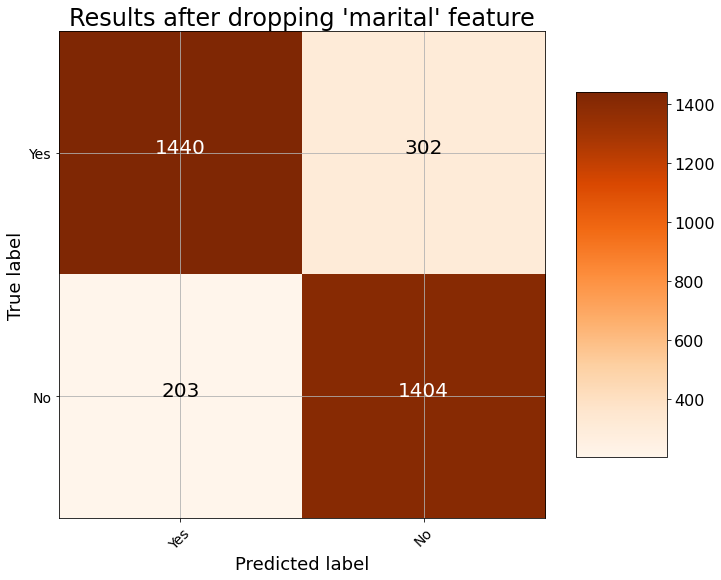

In [133]:
cf = confusion_matrix(y_test, y_pred_rf)
plot_confusion_matrix(cf, title="Results after dropping 'marital' feature")

In [135]:
#Calculating Accuracy of Model using Accuracy_score method
print("Accuracy of the model using Random Forest Algorithm: ", accuracy_score(y_test, y_pred_rf)*100,'%')

Accuracy of the model using Random Forest Algorithm:  84.92087190206031 %


### Observation after removing marital feature and checking

As observed, the accuracy of Random Forest model decreased from 84.  to 84.89%, so we can conclude that Marital Feature's relevance is low/null in our dataset

## 2. Trying to remove education column and see the model performance

In [136]:
data_ed = data.drop('education',axis=1)
data_ed

age          job  marital  default  balance  housing  loan   contact  \
0       59       admin.  married        0     2343        1     0   unknown   
1       56       admin.  married        0       45        0     0   unknown   
2       41   technician  married        0     1270        1     0   unknown   
3       55     services  married        0     2476        1     0   unknown   
4       54       admin.  married        0      184        0     0   unknown   
...    ...          ...      ...      ...      ...      ...   ...       ...   
11157   33  blue-collar   single        0        1        1     0  cellular   
11158   39     services  married        0      733        0     0   unknown   
11159   32   technician   single        0       29        0     0  cellular   
11160   43   technician  married        0        0        0     1  cellular   
11161   34   technician  married        0        0        0     0  cellular   

       day month  duration  campaign  pdays  previous poutcome  deposit  
0        5   may      1042         1     -1         0  unknown        1  
1        5   may      1467         1     -1         0  unknown        1  
2        5   may      1389         1     -1         0  unknown        1  
3        5   may       579         1     -1         0  unknown        1  
4        5   may       673         2     -1         0  unknown        1  
...    ...   ...       ...       ...    ...       ...      ...      ...  
11157   20   apr       257         1     -1         0  unknown        0  
11158   16   jun        83         4     -1         0  unknown        0  
11159   19   aug       156         2     -1         0  unknown        0  
11160    8   may         9         2    172         5  failure        0  
11161    9   jul       628         1     -1         0  unknown        0  

[11162 rows x 16 columns]

In [137]:
X_ed, y_ed, column_list = make_xy(data_marital)

In [138]:
# Make train and test split
X_train, X_test, y_train, y_test = train_test_split(X_ed, y_ed, test_size=0.3, random_state=42)

In [139]:
# Creating and Implementing Random Forest Classifier
rf_model = RandomForestClassifier()
rf_model.fit(X_train , y_train)

RandomForestClassifier()

In [140]:
#Prediction using Random Forest Classifier
y_pred_rf = rf_model.predict(X_test)

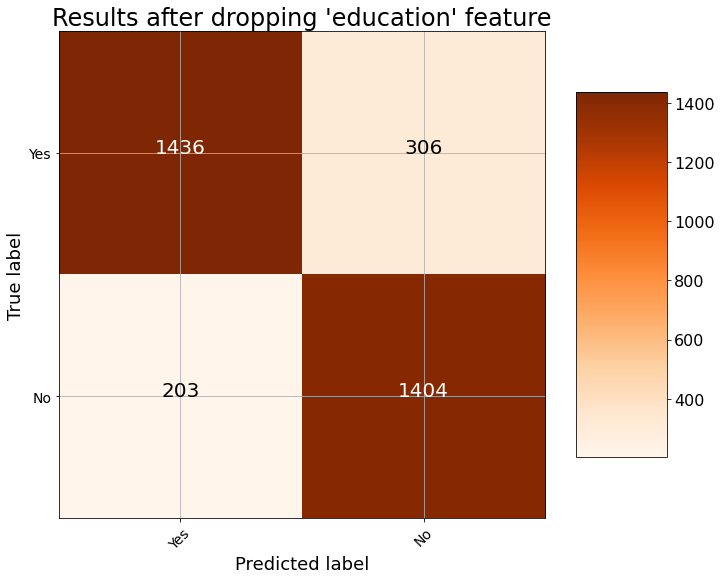

In [141]:
cf = confusion_matrix(y_test, y_pred_rf)
plot_confusion_matrix(cf, title="Results after dropping 'education' feature")

In [143]:
#Calculating Accuracy of Model using Accuracy_score method
print("Accuracy of the model using Random Forest Algorithm: ", accuracy_score(y_test, y_pred_rf)*100,'%')

Accuracy of the model using Random Forest Algorithm:  84.8014332636608 %


### Observation after removing Education feature and checking

As observed, the accuracy of Logistic Regression model didn't change, so we can conclude that Education Feature's relevance is low/null in our dataset

## 3. Trying to remove age column and see the model performance

In [144]:
data_age = data.drop('age',axis=1)
data_age

job  marital  education  default  balance  housing  loan  \
0           admin.  married  secondary        0     2343        1     0   
1           admin.  married  secondary        0       45        0     0   
2       technician  married  secondary        0     1270        1     0   
3         services  married  secondary        0     2476        1     0   
4           admin.  married   tertiary        0      184        0     0   
...            ...      ...        ...      ...      ...      ...   ...   
11157  blue-collar   single    primary        0        1        1     0   
11158     services  married  secondary        0      733        0     0   
11159   technician   single  secondary        0       29        0     0   
11160   technician  married  secondary        0        0        0     1   
11161   technician  married  secondary        0        0        0     0   

        contact  day month  duration  campaign  pdays  previous poutcome  \
0       unknown    5   may      1042         1     -1         0  unknown   
1       unknown    5   may      1467         1     -1         0  unknown   
2       unknown    5   may      1389         1     -1         0  unknown   
3       unknown    5   may       579         1     -1         0  unknown   
4       unknown    5   may       673         2     -1         0  unknown   
...         ...  ...   ...       ...       ...    ...       ...      ...   
11157  cellular   20   apr       257         1     -1         0  unknown   
11158   unknown   16   jun        83         4     -1         0  unknown   
11159  cellular   19   aug       156         2     -1         0  unknown   
11160  cellular    8   may         9         2    172         5  failure   
11161  cellular    9   jul       628         1     -1         0  unknown   

       deposit  
0            1  
1            1  
2            1  
3            1  
4            1  
...        ...  
11157        0  
11158        0  
11159        0  
11160        0  
11161        0  

[11162 rows x 16 columns]

In [145]:
X_age, y_age, column_list = make_xy(data_age)

In [146]:
# Make train and test split
X_train, X_test, y_train, y_test = train_test_split(X_ed, y_ed, test_size=0.3, random_state=42)

In [147]:
# Creating and Implementing Random Forest Classifier
rf_model = RandomForestClassifier()
rf_model.fit(X_train , y_train)

RandomForestClassifier()

In [148]:
#Prediction using Random Forest Classifier
y_pred_rf = rf_model.predict(X_test)

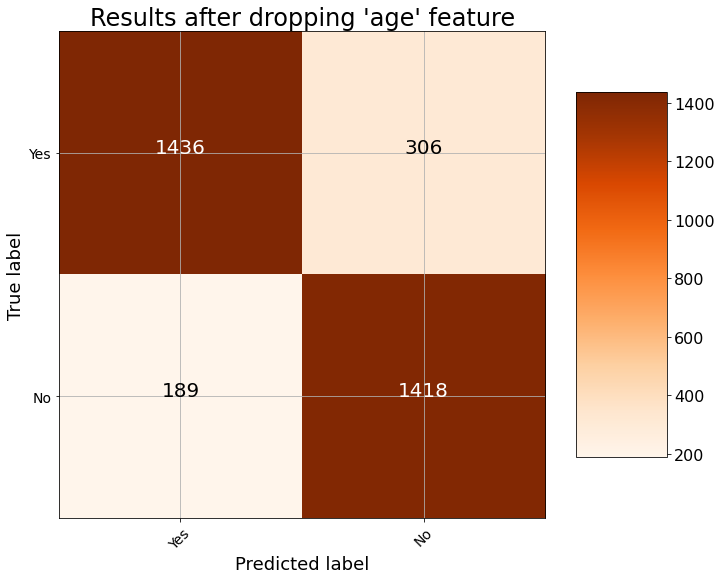

In [149]:
cf = confusion_matrix(y_test, y_pred_rf)
plot_confusion_matrix(cf, title="Results after dropping 'age' feature")

In [151]:
#Calculating Accuracy of Model using Accuracy_score method
print("Accuracy of the model using Random Forest Algorithm: ", accuracy_score(y_test, y_pred_rf)*100,'%')

Accuracy of the model using Random Forest Algorithm:  85.21946849805913 %


### Observation after removing age feature and checking

As observed, the accuracy of Logistic Regression model increased to 81.87% from 81.81%, so we can conclude that Age Feature is relevant in our dataset

## 4. Trying to remove duration column and see the model performance

In [152]:
data_duration = data.drop('duration',axis=1)
data_duration

age          job  marital  education  default  balance  housing  loan  \
0       59       admin.  married  secondary        0     2343        1     0   
1       56       admin.  married  secondary        0       45        0     0   
2       41   technician  married  secondary        0     1270        1     0   
3       55     services  married  secondary        0     2476        1     0   
4       54       admin.  married   tertiary        0      184        0     0   
...    ...          ...      ...        ...      ...      ...      ...   ...   
11157   33  blue-collar   single    primary        0        1        1     0   
11158   39     services  married  secondary        0      733        0     0   
11159   32   technician   single  secondary        0       29        0     0   
11160   43   technician  married  secondary        0        0        0     1   
11161   34   technician  married  secondary        0        0        0     0   

        contact  day month  campaign  pdays  previous poutcome  deposit  
0       unknown    5   may         1     -1         0  unknown        1  
1       unknown    5   may         1     -1         0  unknown        1  
2       unknown    5   may         1     -1         0  unknown        1  
3       unknown    5   may         1     -1         0  unknown        1  
4       unknown    5   may         2     -1         0  unknown        1  
...         ...  ...   ...       ...    ...       ...      ...      ...  
11157  cellular   20   apr         1     -1         0  unknown        0  
11158   unknown   16   jun         4     -1         0  unknown        0  
11159  cellular   19   aug         2     -1         0  unknown        0  
11160  cellular    8   may         2    172         5  failure        0  
11161  cellular    9   jul         1     -1         0  unknown        0  

[11162 rows x 16 columns]

In [153]:
X_duration, y_duration, column_list = make_xy(data_duration)

In [154]:
# Make train and test split
X_train, X_test, y_train, y_test = train_test_split(X_duration, y_duration, test_size=0.3, random_state=42)

In [155]:
# Creating and Implementing Random Forest Classifier
rf_model = RandomForestClassifier()
rf_model.fit(X_train , y_train)

RandomForestClassifier()

In [156]:
#Prediction using Random Forest Classifier
y_pred_rf = rf_model.predict(X_test)

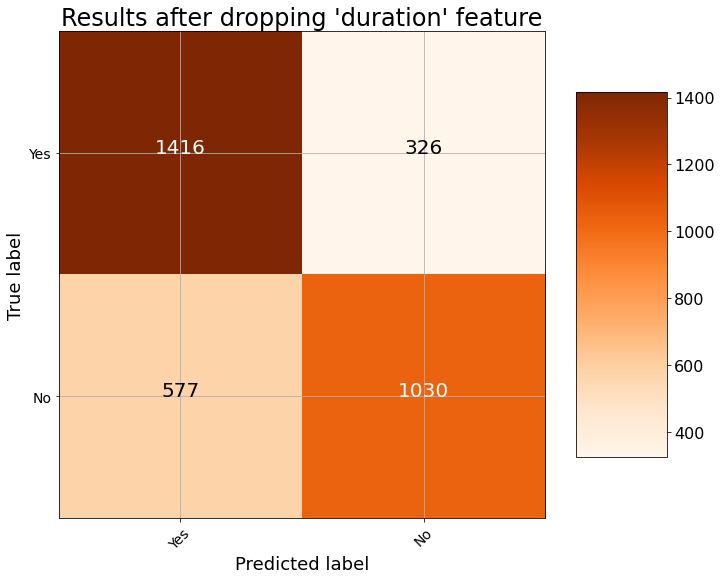

In [157]:
cf = confusion_matrix(y_test, y_pred_rf)
plot_confusion_matrix(cf, title="Results after dropping 'duration' feature")

In [159]:
#Calculating Accuracy of Model using Accuracy_score method
print("Accuracy of the model using Random Forest Algorithm: ", accuracy_score(y_test, y_pred_rf)*100,'%')

Accuracy of the model using Random Forest Algorithm:  73.03672738130786 %


### Observation after removing duration feature and checking

As observed, the accuracy of Logistic Regression model decreased to 70.46% from 81.81%, so we can conclude that Duration Feature(last contact duration) is highly relevant in our dataset

## 5. Trying to remove balance column and see the model performance

In [160]:
data_balance = data.drop('balance',axis=1)
data_balance

age          job  marital  education  default  housing  loan   contact  \
0       59       admin.  married  secondary        0        1     0   unknown   
1       56       admin.  married  secondary        0        0     0   unknown   
2       41   technician  married  secondary        0        1     0   unknown   
3       55     services  married  secondary        0        1     0   unknown   
4       54       admin.  married   tertiary        0        0     0   unknown   
...    ...          ...      ...        ...      ...      ...   ...       ...   
11157   33  blue-collar   single    primary        0        1     0  cellular   
11158   39     services  married  secondary        0        0     0   unknown   
11159   32   technician   single  secondary        0        0     0  cellular   
11160   43   technician  married  secondary        0        0     1  cellular   
11161   34   technician  married  secondary        0        0     0  cellular   

       day month  duration  campaign  pdays  previous poutcome  deposit  
0        5   may      1042         1     -1         0  unknown        1  
1        5   may      1467         1     -1         0  unknown        1  
2        5   may      1389         1     -1         0  unknown        1  
3        5   may       579         1     -1         0  unknown        1  
4        5   may       673         2     -1         0  unknown        1  
...    ...   ...       ...       ...    ...       ...      ...      ...  
11157   20   apr       257         1     -1         0  unknown        0  
11158   16   jun        83         4     -1         0  unknown        0  
11159   19   aug       156         2     -1         0  unknown        0  
11160    8   may         9         2    172         5  failure        0  
11161    9   jul       628         1     -1         0  unknown        0  

[11162 rows x 16 columns]

In [161]:
X_balance, y_balance, column_list = make_xy(data_balance)

In [162]:
# Make train and test split
X_train, X_test, y_train, y_test = train_test_split(X_balance, y_balance, test_size=0.3, random_state=42)

In [163]:
# Creating and Implementing Random Forest Classifier
rf_model = RandomForestClassifier()
rf_model.fit(X_train , y_train)

RandomForestClassifier()

In [164]:
#Prediction using Random Forest Classifier
y_pred_rf = rf_model.predict(X_test)

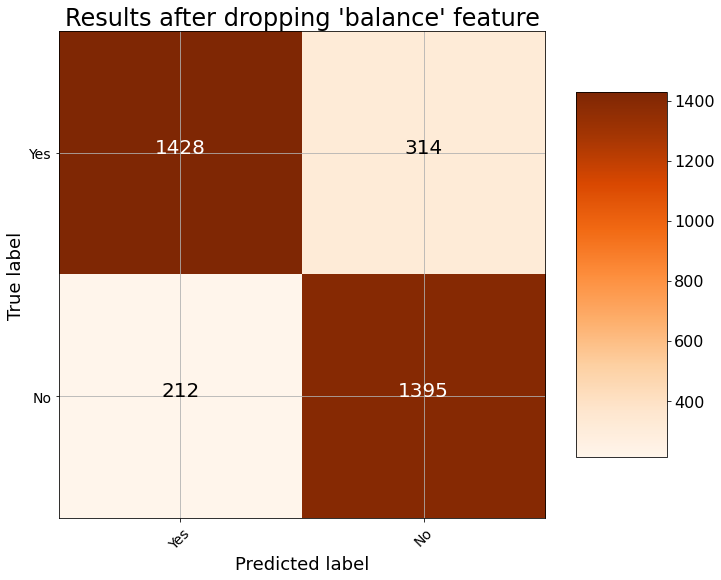

In [166]:
cf = confusion_matrix(y_test, y_pred_rf)
plot_confusion_matrix(cf, title="Results after dropping 'balance' feature")

In [168]:
#Calculating Accuracy of Model using Accuracy_score method
print("Accuracy of the model using Random Forest Algorithm: ", accuracy_score(y_test, y_pred_rf)*100,'%')

Accuracy of the model using Random Forest Algorithm:  84.29381905046283 %


### Observation after removing balance feature and checking

As observed, the accuracy of Logistic Regression model decreased to 81.75% from 81.81%, so we can conclude that Balance Feature is relevant in our dataset

# Stochastic Gradient Descent

In [171]:
SGD_model = SGDClassifier(max_iter=1000, tol=0.001, random_state=42)

In [172]:
SGD_model.fit(X_train,y_train)

SGDClassifier(random_state=42)

In [173]:
SGD_predictions = SGD_model.predict(X_test)

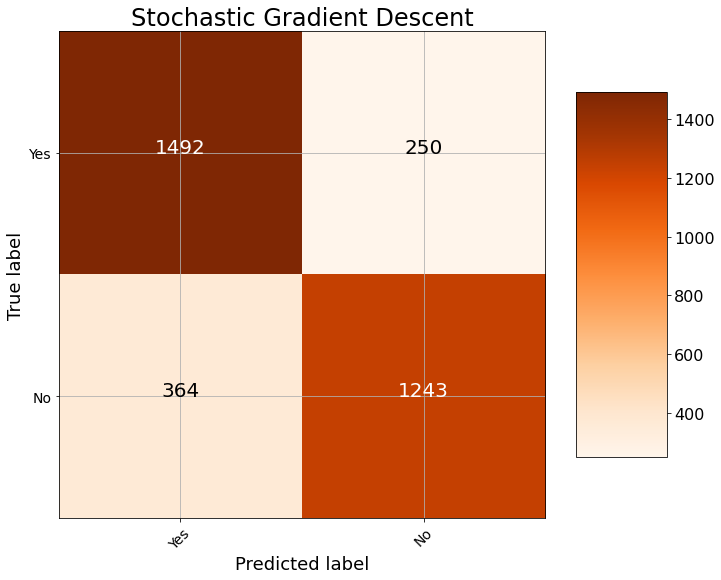

In [175]:
cf = confusion_matrix(y_test,SGD_predictions)
plot_confusion_matrix(cf, title="Stochastic Gradient Descent")

In [177]:
#Calculating the accuracy of SVC model
print(f"Accuracy of SGD model is: {accuracy_score(y_test, SGD_predictions)*100}%")

Accuracy of SGD model is: 81.66616900567334%


## Using GridSearchCV to tune the hyperparameters

In [178]:
sgdc = SGDClassifier()

param_grid = {
    'loss':['hinge','log'],
    'penalty':['l2','l1','elasticnet'] ,    
    'alpha':[0.001,0.0001,0.00001],
    'l1_ratio':[0.05,0.06,0.07,0.08,0.09,0.1,0.12,0.13,0.14,0.15,0.2]
}

In [179]:
grid_sgdc = GridSearchCV(sgdc, param_grid, cv=5, verbose=1, n_jobs=-1)
grid_sgdc.fit(X_train, y_train)

Fitting 5 folds for each of 198 candidates, totalling 990 fits


GridSearchCV(cv=5, estimator=SGDClassifier(), n_jobs=-1,
             param_grid={'alpha': [0.001, 0.0001, 1e-05],
                         'l1_ratio': [0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.12,
                                      0.13, 0.14, 0.15, 0.2],
                         'loss': ['hinge', 'log'],
                         'penalty': ['l2', 'l1', 'elasticnet']},
             verbose=1)

In [180]:
grid_sgdc.best_params_

{'alpha': 0.001, 'l1_ratio': 0.15, 'loss': 'hinge', 'penalty': 'l1'}

In [181]:
#The best estimator
grid_sgdc.best_estimator_

SGDClassifier(alpha=0.001, penalty='l1')

In [182]:
grid_sgdc_predictions = grid_sgdc.predict(X_test)

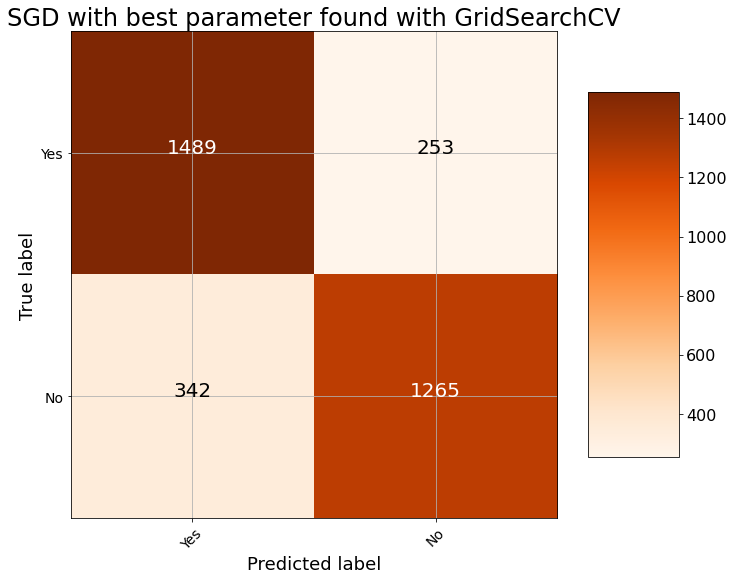

In [184]:
grid_sgdc_cf = confusion_matrix(y_test, grid_sgdc_predictions)
plot_confusion_matrix(grid_sgdc_cf, title="SGD with best parameter found with GridSearchCV")

In [185]:
#Accuracy of the optimised SVC
print(f"Accuracy: {accuracy_score(y_test, grid_sgdc_predictions)*100}%")

Accuracy: 82.23350253807106%


In [186]:
#Comparing the accuracies 
print(f"SGD Accuracy: {accuracy_score(y_test, SGD_predictions)*100}%")
print(f"GridSearchCV accuracy: {accuracy_score(y_test, grid_sgdc_predictions)*100}%")

SGD Accuracy: 81.66616900567334%
GridSearchCV accuracy: 82.23350253807106%


### Observation
By using GridSearchCV we were able to improve the accuracy of our SGD classifier from 81.55% to 81.76%.

The optimised classifier is SGDClassifier(l1_ratio=0.14, penalty='l1')

## 1. Checking the performace after removing job column

In [187]:
data_job_remove = data.drop('job', axis=1)
data_job_remove.head()

age  marital  education  default  balance  housing  loan  contact  day  \
0   59  married  secondary        0     2343        1     0  unknown    5   
1   56  married  secondary        0       45        0     0  unknown    5   
2   41  married  secondary        0     1270        1     0  unknown    5   
3   55  married  secondary        0     2476        1     0  unknown    5   
4   54  married   tertiary        0      184        0     0  unknown    5   

  month  duration  campaign  pdays  previous poutcome  deposit  
0   may      1042         1     -1         0  unknown        1  
1   may      1467         1     -1         0  unknown        1  
2   may      1389         1     -1         0  unknown        1  
3   may       579         1     -1         0  unknown        1  
4   may       673         2     -1         0  unknown        1

In [188]:
X_job, y_job, columns_list = make_xy(data_job_remove)

In [189]:
X_train, X_test, y_train, y_test = train_test_split(X_job, y_job, test_size=0.3, random_state=42)

In [190]:
sgd = SGDClassifier(l1_ratio=0.14, penalty='l1')
sgd.fit(X_train, y_train)

SGDClassifier(l1_ratio=0.14, penalty='l1')

In [191]:
y_pred = sgd.predict(X_test)

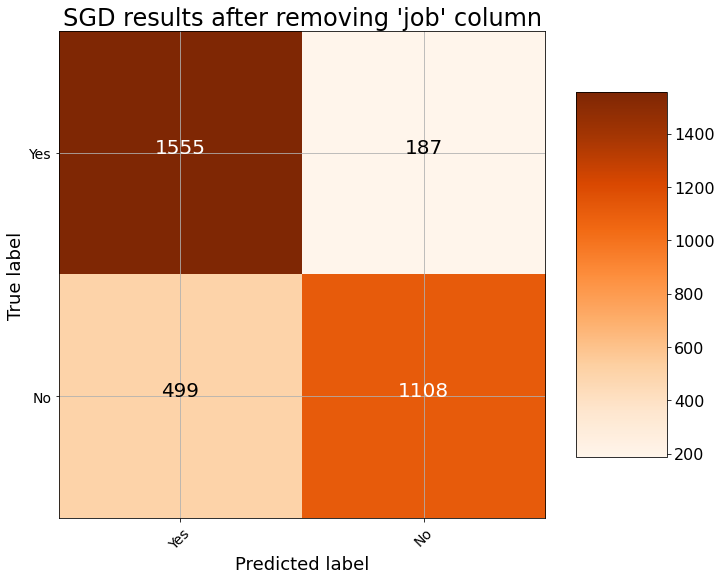

In [281]:
cf = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cf, title="SGD results after removing 'job' column")

In [193]:
#Calculating the accuracy after dropping job column
print(f"Accuracy: {accuracy_score(y_test, y_pred)*100}%")

Accuracy: 81.69602866527322%


### Observation after removing job column and checking accuracy

The accuracy of the model increases from 81.76% to 81.63% after removing the job column. Hence, concluding that the feature is relevant to our dataset.


## 2. Checking the performace after removing month column

In [194]:
data_month_remove = data.drop('month', axis=1)
data_month_remove.head()

age         job  marital  education  default  balance  housing  loan  \
0   59      admin.  married  secondary        0     2343        1     0   
1   56      admin.  married  secondary        0       45        0     0   
2   41  technician  married  secondary        0     1270        1     0   
3   55    services  married  secondary        0     2476        1     0   
4   54      admin.  married   tertiary        0      184        0     0   

   contact  day  duration  campaign  pdays  previous poutcome  deposit  
0  unknown    5      1042         1     -1         0  unknown        1  
1  unknown    5      1467         1     -1         0  unknown        1  
2  unknown    5      1389         1     -1         0  unknown        1  
3  unknown    5       579         1     -1         0  unknown        1  
4  unknown    5       673         2     -1         0  unknown        1

In [195]:
X_month, y_month, columns_list = make_xy(data_month_remove)

In [196]:
X_train, X_test, y_train, y_test = train_test_split(X_month, y_month, test_size=0.3, random_state=42)

In [197]:
sgd = SGDClassifier(l1_ratio=0.14, penalty='l1')
sgd.fit(X_train, y_train)

SGDClassifier(l1_ratio=0.14, penalty='l1')

In [198]:
y_pred = sgd.predict(X_test)

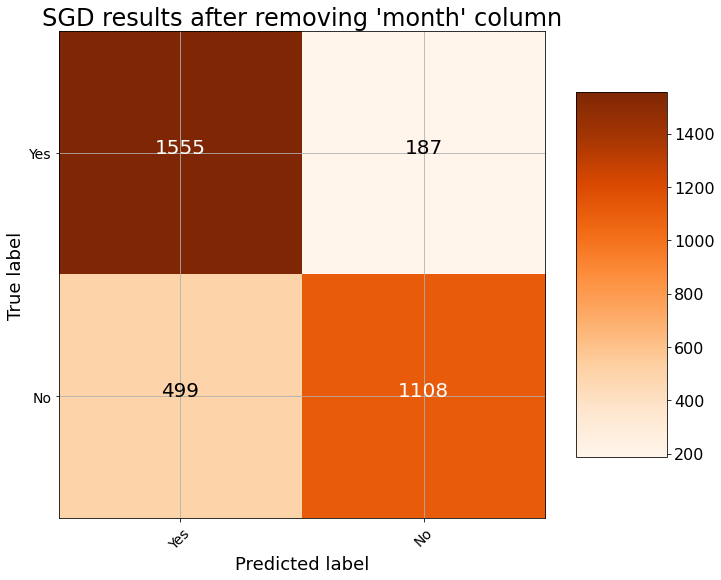

In [280]:
cf = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cf, title="SGD results after removing 'month' column")

In [200]:
#Calculating the accuracy after dropping job column
print(f"Accuracy: {accuracy_score(y_test, y_pred)*100}%")

Accuracy: 80.44192296207822%


### Observation after removing month column and checking accuracy

The accuracy of the model is reduced from 78.59% to 76.86% after removing the month column. Hence, concluding that the feature is relevant to our dataset.


## 3. Checking the performace after removing campaign column

In [201]:
data_campaign_remove = data.drop('campaign', axis=1)
data_campaign_remove.head()

age         job  marital  education  default  balance  housing  loan  \
0   59      admin.  married  secondary        0     2343        1     0   
1   56      admin.  married  secondary        0       45        0     0   
2   41  technician  married  secondary        0     1270        1     0   
3   55    services  married  secondary        0     2476        1     0   
4   54      admin.  married   tertiary        0      184        0     0   

   contact  day month  duration  pdays  previous poutcome  deposit  
0  unknown    5   may      1042     -1         0  unknown        1  
1  unknown    5   may      1467     -1         0  unknown        1  
2  unknown    5   may      1389     -1         0  unknown        1  
3  unknown    5   may       579     -1         0  unknown        1  
4  unknown    5   may       673     -1         0  unknown        1

In [202]:
X_campaign, y_campaign, columns_list = make_xy(data_campaign_remove)

In [203]:
X_train, X_test, y_train, y_test = train_test_split(X_campaign, y_campaign, test_size=0.3, random_state=42)

In [204]:
sgd = SGDClassifier(l1_ratio=0.14, penalty='l1')
sgd.fit(X_train, y_train)

SGDClassifier(l1_ratio=0.14, penalty='l1')

In [205]:
y_pred = sgd.predict(X_test)

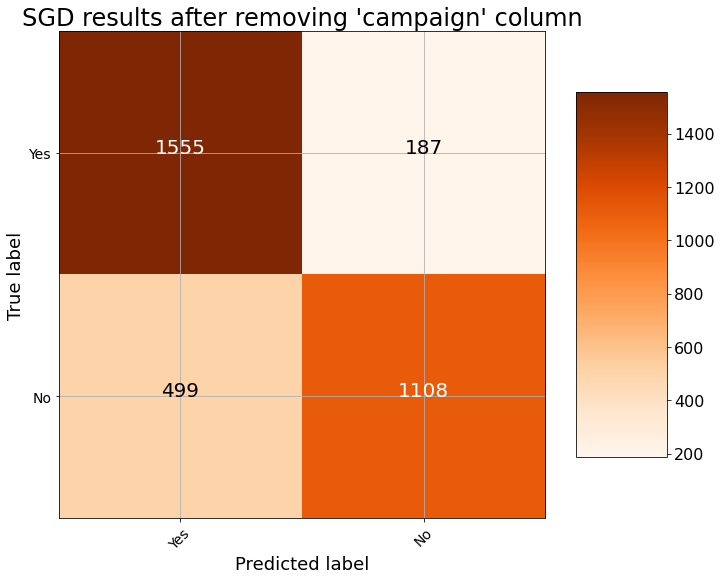

In [279]:
cf = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cf, title="SGD results after removing 'campaign' column")

In [207]:
#Calculating the accuracy after dropping job column
print(f"Accuracy: {accuracy_score(y_test, y_pred)*100}%")

Accuracy: 82.50223947447%


### Observation after removing campaign columns and checking accuracy

As we can see there is significant improvement a model is seeing after removing this feature. 

## 4. Checking the performace after removing education column

In [208]:
data_education = data.drop('education',axis=1)
data_education

age          job  marital  default  balance  housing  loan   contact  \
0       59       admin.  married        0     2343        1     0   unknown   
1       56       admin.  married        0       45        0     0   unknown   
2       41   technician  married        0     1270        1     0   unknown   
3       55     services  married        0     2476        1     0   unknown   
4       54       admin.  married        0      184        0     0   unknown   
...    ...          ...      ...      ...      ...      ...   ...       ...   
11157   33  blue-collar   single        0        1        1     0  cellular   
11158   39     services  married        0      733        0     0   unknown   
11159   32   technician   single        0       29        0     0  cellular   
11160   43   technician  married        0        0        0     1  cellular   
11161   34   technician  married        0        0        0     0  cellular   

       day month  duration  campaign  pdays  previous poutcome  deposit  
0        5   may      1042         1     -1         0  unknown        1  
1        5   may      1467         1     -1         0  unknown        1  
2        5   may      1389         1     -1         0  unknown        1  
3        5   may       579         1     -1         0  unknown        1  
4        5   may       673         2     -1         0  unknown        1  
...    ...   ...       ...       ...    ...       ...      ...      ...  
11157   20   apr       257         1     -1         0  unknown        0  
11158   16   jun        83         4     -1         0  unknown        0  
11159   19   aug       156         2     -1         0  unknown        0  
11160    8   may         9         2    172         5  failure        0  
11161    9   jul       628         1     -1         0  unknown        0  

[11162 rows x 16 columns]

In [209]:
X_ed, y_ed, column_list = make_xy(data_education)

In [210]:
# Make train and test split
X_train, X_test, y_train, y_test = train_test_split(X_ed, y_ed, test_size=0.3, random_state=42)

In [211]:
sgd = SGDClassifier(l1_ratio=0.14, penalty='l1')
sgd.fit(X_train, y_train)

SGDClassifier(l1_ratio=0.14, penalty='l1')

In [212]:
y_pred = sgd.predict(X_test)

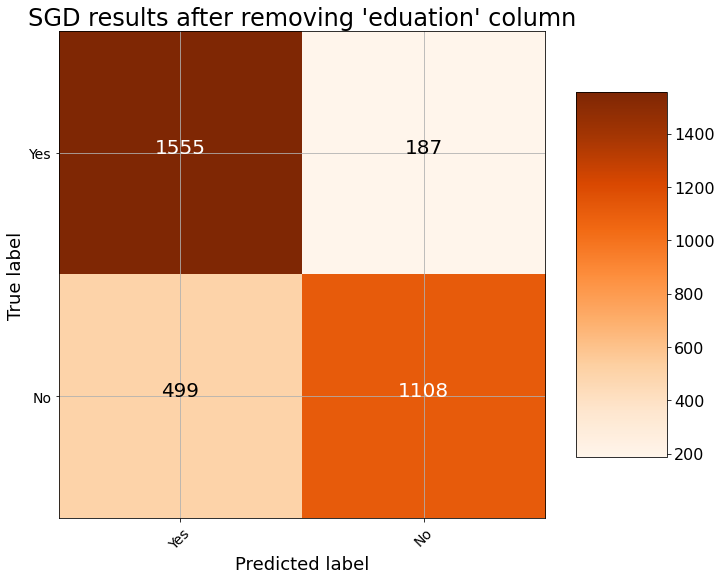

In [278]:
cf = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cf, title="SGD results after removing 'eduation' column")

In [214]:
#Calculating the accuracy after dropping job column
print(f"Accuracy: {accuracy_score(y_test, y_pred)*100}%")

Accuracy: 81.36757240967452%


### Observation after removing education column and checking accuracy

As we see slight increase in the accuracy from 78.59% to 78.94%, we can conclude that the education feature is relevant to our dataset.

## 5. Trying to remove age column and see the model performance

In [215]:
data_age = data.drop('age',axis=1)
data_age

job  marital  education  default  balance  housing  loan  \
0           admin.  married  secondary        0     2343        1     0   
1           admin.  married  secondary        0       45        0     0   
2       technician  married  secondary        0     1270        1     0   
3         services  married  secondary        0     2476        1     0   
4           admin.  married   tertiary        0      184        0     0   
...            ...      ...        ...      ...      ...      ...   ...   
11157  blue-collar   single    primary        0        1        1     0   
11158     services  married  secondary        0      733        0     0   
11159   technician   single  secondary        0       29        0     0   
11160   technician  married  secondary        0        0        0     1   
11161   technician  married  secondary        0        0        0     0   

        contact  day month  duration  campaign  pdays  previous poutcome  \
0       unknown    5   may      1042         1     -1         0  unknown   
1       unknown    5   may      1467         1     -1         0  unknown   
2       unknown    5   may      1389         1     -1         0  unknown   
3       unknown    5   may       579         1     -1         0  unknown   
4       unknown    5   may       673         2     -1         0  unknown   
...         ...  ...   ...       ...       ...    ...       ...      ...   
11157  cellular   20   apr       257         1     -1         0  unknown   
11158   unknown   16   jun        83         4     -1         0  unknown   
11159  cellular   19   aug       156         2     -1         0  unknown   
11160  cellular    8   may         9         2    172         5  failure   
11161  cellular    9   jul       628         1     -1         0  unknown   

       deposit  
0            1  
1            1  
2            1  
3            1  
4            1  
...        ...  
11157        0  
11158        0  
11159        0  
11160        0  
11161        0  

[11162 rows x 16 columns]

In [216]:
X_age, y_age, column_list = make_xy(data_age)

In [217]:
# Make train and test split
X_train, X_test, y_train, y_test = train_test_split(X_age, y_age, test_size=0.3, random_state=42)

In [218]:
sgd = SGDClassifier(l1_ratio=0.14, penalty='l1')
sgd.fit(X_train, y_train)

SGDClassifier(l1_ratio=0.14, penalty='l1')

In [219]:
y_pred = sgd.predict(X_test)

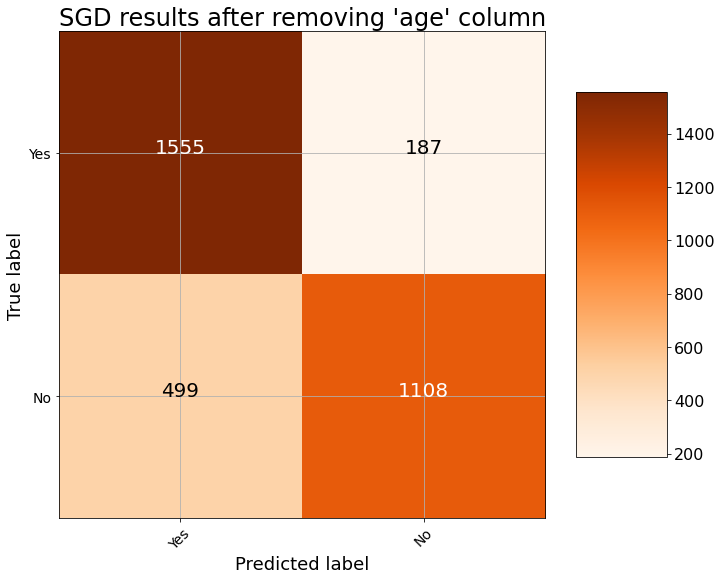

In [277]:
cf = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cf, title="SGD results after removing 'age' column")

In [221]:
#Calculating the accuracy after dropping job column
print(f"Accuracy: {accuracy_score(y_test, y_pred)*100}%")

Accuracy: 82.44252015527023%


### Observation after removing age column and checking accuracy

As we see slight increase in the accuracy from 81.76% to 81.82%, we can conclude that the education feature is relevant to our dataset.


# Support  Vector Classifier

In [223]:
#Creating a SVC Classifier object and fitting it with training data
svc = SVC(gamma='auto')
svc.fit(X_train, y_train)

SVC(gamma='auto')

In [224]:
#Predicting values using the trained model on the test data
y_pred = svc.predict(X_test)

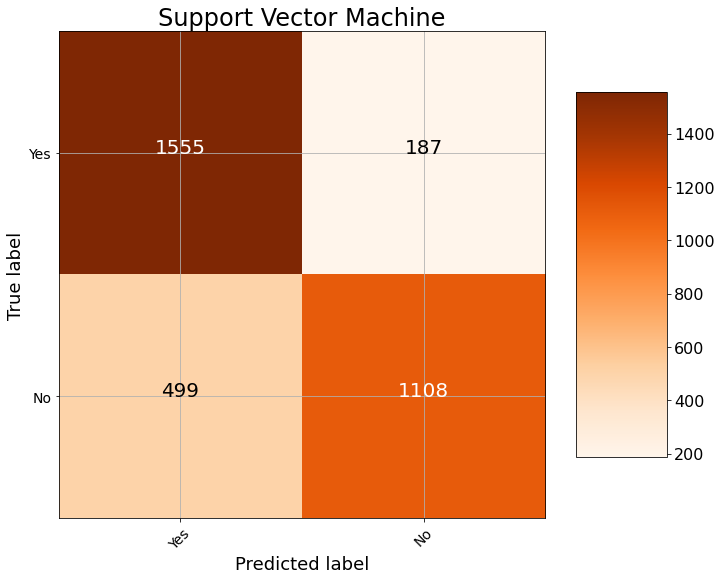

In [227]:
cf_svc = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cf_svc, title="Support Vector Machine")

In [229]:
#Calculating the accuracy of SVC model
print(f"Accuracy of SVC model is: {accuracy_score(y_test, y_pred)*100}%")

Accuracy of SVC model is: 79.51627351448194%


## Using GridSearchCV to tune the hyperparameters

In [230]:
param_grid = {'gamma':[0.001, 0.01, 0.1, 1], 'C':[0.1, 1, 10, 100], 'kernel':['linear', 'poly', 'rbf', 'sigmoid']}

In [233]:
grid_svc = GridSearchCV(SVC(), param_grid, refit=True, verbose=3, n_jobs=-1)
grid_svc.fit(X_train, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             verbose=3)

In [234]:
#Parameters that gave the best result
grid_svc.best_params_

{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}

In [235]:
#The best estimator
grid_svc.best_estimator_

SVC(C=100, gamma=0.01)

In [236]:
grid_svc_predictions = grid_svc.predict(X_test)

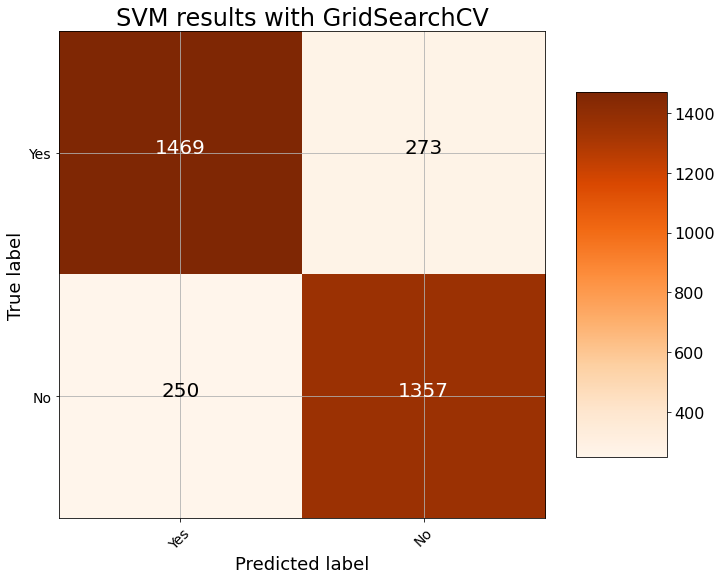

In [237]:
grid_svc_cf = confusion_matrix(y_test, grid_svc_predictions)
plot_confusion_matrix(grid_svc_cf, title="SVM results with GridSearchCV")

In [238]:
#Accuracy of the optimised SVC
print(f"Accuracy: {accuracy_score(y_test, grid_svc_predictions)*100}%")

Accuracy: 84.38339802926247%


In [239]:
#Comparing the accuracies 
print(f"SVC Accuracy: {accuracy_score(y_test, y_pred)*100}%")
print(f"GridSearchCV accuracy: {accuracy_score(y_test, grid_svc_predictions)*100}%")

SVC Accuracy: 79.51627351448194%
GridSearchCV accuracy: 84.38339802926247%


### Observation
By using GridSearchCV we were able to improve the accuracy of our SVC classifier from 78.59% to 83.64%.

The optimised classifier is SVC(C=10, gamma=0.1, kernel='rbf')

## 1. Checking the performace after removing job column

In [240]:
data_job_remove = data.drop('job', axis=1)
data_job_remove.head()

age  marital  education  default  balance  housing  loan  contact  day  \
0   59  married  secondary        0     2343        1     0  unknown    5   
1   56  married  secondary        0       45        0     0  unknown    5   
2   41  married  secondary        0     1270        1     0  unknown    5   
3   55  married  secondary        0     2476        1     0  unknown    5   
4   54  married   tertiary        0      184        0     0  unknown    5   

  month  duration  campaign  pdays  previous poutcome  deposit  
0   may      1042         1     -1         0  unknown        1  
1   may      1467         1     -1         0  unknown        1  
2   may      1389         1     -1         0  unknown        1  
3   may       579         1     -1         0  unknown        1  
4   may       673         2     -1         0  unknown        1

In [241]:
X_job, y_job, columns_list = make_xy(data_job_remove)

In [242]:
X_train, X_test, y_train, y_test = train_test_split(X_job, y_job, test_size=0.3, random_state=42)

In [243]:
svc=SVC(gamma='auto')
svc.fit(X_train, y_train)

SVC(gamma='auto')

In [244]:
y_pred = svc.predict(X_test)

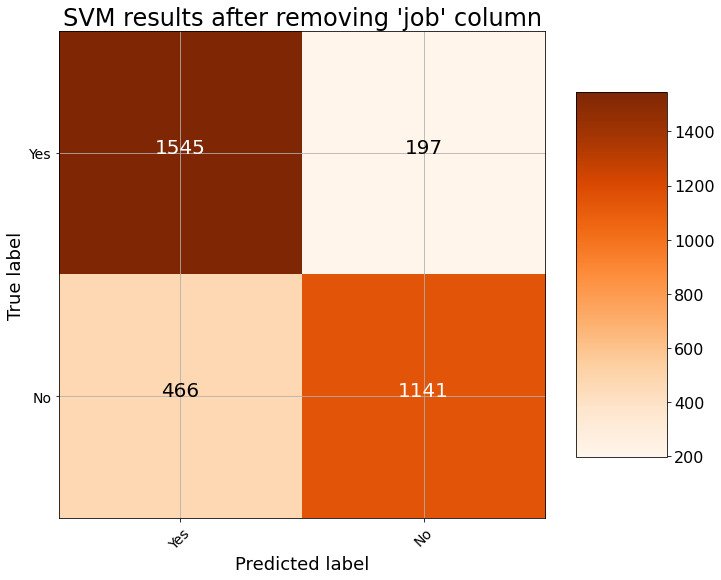

In [246]:
cf = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cf, title="SVM results after removing 'job' column")

In [247]:
#Calculating the accuracy after dropping job column
print(f"Accuracy: {accuracy_score(y_test, y_pred)*100}%")

Accuracy: 80.20304568527918%


### Observation after removing job column and checking accuracy

The accuracy of the model increases from 78.59% to 79.24% after removing the job column. Hence, concluding that the feature is relevant to our dataset.


## 2. Checking the performace after removing month column

In [248]:
data_month_remove = data.drop('month', axis=1)
data_month_remove.head()

age         job  marital  education  default  balance  housing  loan  \
0   59      admin.  married  secondary        0     2343        1     0   
1   56      admin.  married  secondary        0       45        0     0   
2   41  technician  married  secondary        0     1270        1     0   
3   55    services  married  secondary        0     2476        1     0   
4   54      admin.  married   tertiary        0      184        0     0   

   contact  day  duration  campaign  pdays  previous poutcome  deposit  
0  unknown    5      1042         1     -1         0  unknown        1  
1  unknown    5      1467         1     -1         0  unknown        1  
2  unknown    5      1389         1     -1         0  unknown        1  
3  unknown    5       579         1     -1         0  unknown        1  
4  unknown    5       673         2     -1         0  unknown        1

In [249]:
X_month, y_month, columns_list = make_xy(data_month_remove)

In [250]:
X_train, X_test, y_train, y_test = train_test_split(X_month, y_month, test_size=0.3, random_state=42)

In [251]:
svc=SVC(gamma='auto')
svc.fit(X_train, y_train)

SVC(gamma='auto')

In [252]:
y_pred = svc.predict(X_test)

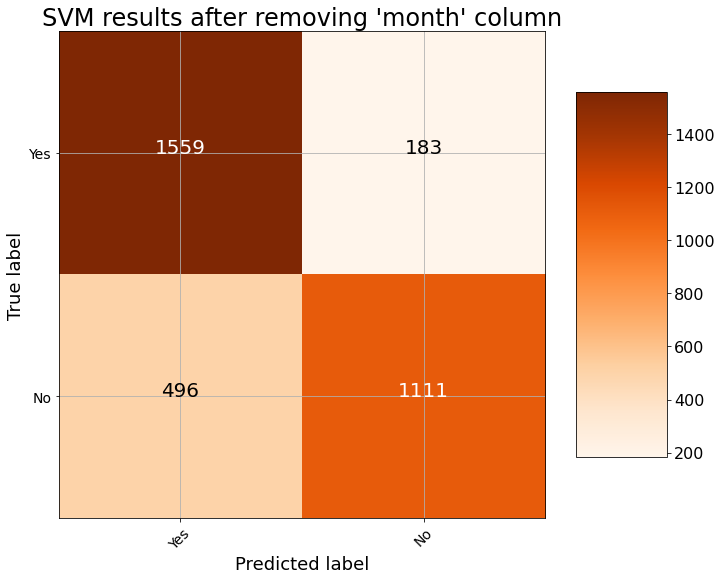

In [260]:
cf = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cf, title="SVM results after removing 'month' column")

In [254]:
#Calculating the accuracy after dropping job column
print(f"Accuracy: {accuracy_score(y_test, y_pred)*100}%")

Accuracy: 77.8739922364885%


### Observation after removing month column and checking accuracy

The accuracy of the model is reduced from 78.59% to 76.86% after removing the month column. Hence, concluding that the feature is relevant to our dataset.


## 3. Checking the performace after removing campaign column

In [255]:
data_campaign_remove = data.drop('campaign', axis=1)
data_campaign_remove.head()

age         job  marital  education  default  balance  housing  loan  \
0   59      admin.  married  secondary        0     2343        1     0   
1   56      admin.  married  secondary        0       45        0     0   
2   41  technician  married  secondary        0     1270        1     0   
3   55    services  married  secondary        0     2476        1     0   
4   54      admin.  married   tertiary        0      184        0     0   

   contact  day month  duration  pdays  previous poutcome  deposit  
0  unknown    5   may      1042     -1         0  unknown        1  
1  unknown    5   may      1467     -1         0  unknown        1  
2  unknown    5   may      1389     -1         0  unknown        1  
3  unknown    5   may       579     -1         0  unknown        1  
4  unknown    5   may       673     -1         0  unknown        1

In [256]:
X_campaign, y_campaign, columns_list = make_xy(data_campaign_remove)

In [257]:
X_train, X_test, y_train, y_test = train_test_split(X_campaign, y_campaign, test_size=0.3, random_state=42)

In [258]:
svc=SVC(gamma='auto')
svc.fit(X_train, y_train)

SVC(gamma='auto')

In [259]:
y_pred = svc.predict(X_test)

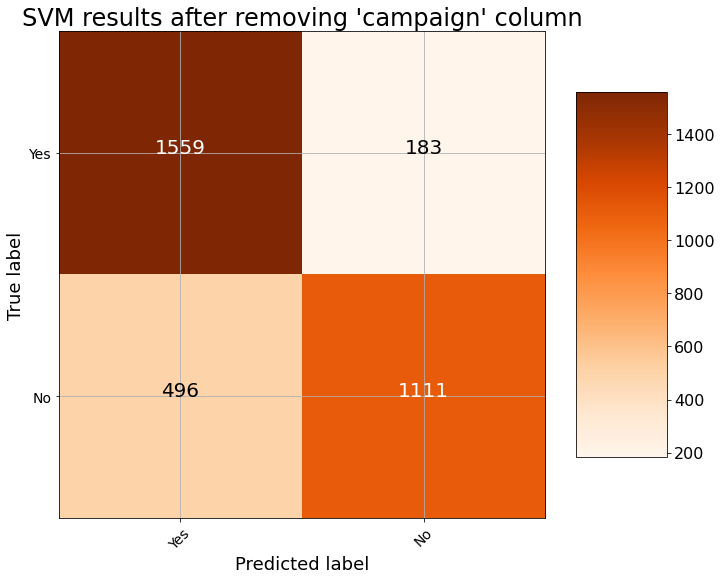

In [261]:
cf = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cf, title="SVM results after removing 'campaign' column")

In [262]:
#Calculating the accuracy after dropping job column
print(f"Accuracy: {accuracy_score(y_test, y_pred)*100}%")

Accuracy: 79.7252911316811%


### Observation after removing campaign columns and checking accuracy

As we see almost no change in the accuracy of our model, therefore we can conclude that campaign columns has miniscule impact on our dataset.

## 4. Checking the performace after removing education column

In [263]:
data_education = data.drop('education',axis=1)
data_education

age          job  marital  default  balance  housing  loan   contact  \
0       59       admin.  married        0     2343        1     0   unknown   
1       56       admin.  married        0       45        0     0   unknown   
2       41   technician  married        0     1270        1     0   unknown   
3       55     services  married        0     2476        1     0   unknown   
4       54       admin.  married        0      184        0     0   unknown   
...    ...          ...      ...      ...      ...      ...   ...       ...   
11157   33  blue-collar   single        0        1        1     0  cellular   
11158   39     services  married        0      733        0     0   unknown   
11159   32   technician   single        0       29        0     0  cellular   
11160   43   technician  married        0        0        0     1  cellular   
11161   34   technician  married        0        0        0     0  cellular   

       day month  duration  campaign  pdays  previous poutcome  deposit  
0        5   may      1042         1     -1         0  unknown        1  
1        5   may      1467         1     -1         0  unknown        1  
2        5   may      1389         1     -1         0  unknown        1  
3        5   may       579         1     -1         0  unknown        1  
4        5   may       673         2     -1         0  unknown        1  
...    ...   ...       ...       ...    ...       ...      ...      ...  
11157   20   apr       257         1     -1         0  unknown        0  
11158   16   jun        83         4     -1         0  unknown        0  
11159   19   aug       156         2     -1         0  unknown        0  
11160    8   may         9         2    172         5  failure        0  
11161    9   jul       628         1     -1         0  unknown        0  

[11162 rows x 16 columns]

In [264]:
X_ed, y_ed, column_list = make_xy(data_education)

In [265]:
# Make train and test split
X_train, X_test, y_train, y_test = train_test_split(X_ed, y_ed, test_size=0.3, random_state=42)

In [266]:
svc=SVC(gamma='auto')
svc.fit(X_train, y_train)

SVC(gamma='auto')

In [267]:
y_pred = svc.predict(X_test)

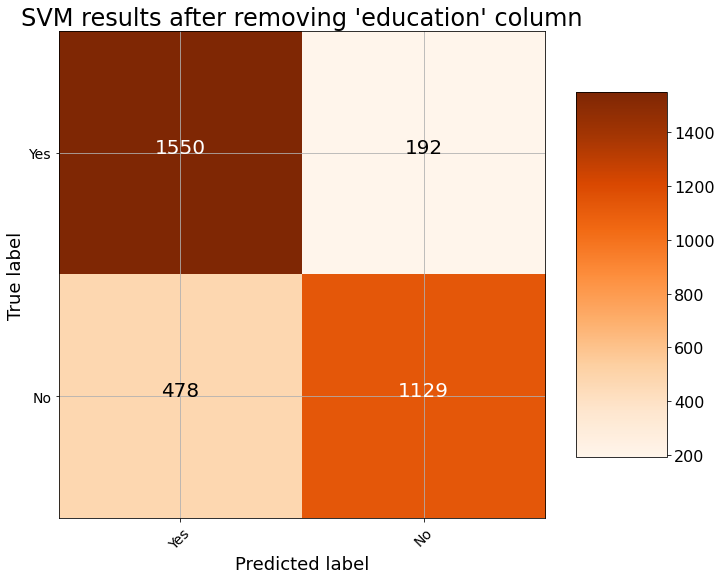

In [268]:
cf = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cf, title="SVM results after removing 'education' column")

In [269]:
#Calculating the accuracy after dropping job column
print(f"Accuracy: {accuracy_score(y_test, y_pred)*100}%")

Accuracy: 79.99402806808003%


### Observation after removing education column and checking accuracy

As we see slight increase in the accuracy from 78.59% to 78.94%, we can conclude that the education feature is relevant to our dataset.

## 5. Trying to remove age column and see the model performance

In [270]:
data_age = data.drop('age',axis=1)
data_age

job  marital  education  default  balance  housing  loan  \
0           admin.  married  secondary        0     2343        1     0   
1           admin.  married  secondary        0       45        0     0   
2       technician  married  secondary        0     1270        1     0   
3         services  married  secondary        0     2476        1     0   
4           admin.  married   tertiary        0      184        0     0   
...            ...      ...        ...      ...      ...      ...   ...   
11157  blue-collar   single    primary        0        1        1     0   
11158     services  married  secondary        0      733        0     0   
11159   technician   single  secondary        0       29        0     0   
11160   technician  married  secondary        0        0        0     1   
11161   technician  married  secondary        0        0        0     0   

        contact  day month  duration  campaign  pdays  previous poutcome  \
0       unknown    5   may      1042         1     -1         0  unknown   
1       unknown    5   may      1467         1     -1         0  unknown   
2       unknown    5   may      1389         1     -1         0  unknown   
3       unknown    5   may       579         1     -1         0  unknown   
4       unknown    5   may       673         2     -1         0  unknown   
...         ...  ...   ...       ...       ...    ...       ...      ...   
11157  cellular   20   apr       257         1     -1         0  unknown   
11158   unknown   16   jun        83         4     -1         0  unknown   
11159  cellular   19   aug       156         2     -1         0  unknown   
11160  cellular    8   may         9         2    172         5  failure   
11161  cellular    9   jul       628         1     -1         0  unknown   

       deposit  
0            1  
1            1  
2            1  
3            1  
4            1  
...        ...  
11157        0  
11158        0  
11159        0  
11160        0  
11161        0  

[11162 rows x 16 columns]

In [271]:
X_age, y_age, column_list = make_xy(data_age)

In [272]:
# Make train and test split
X_train, X_test, y_train, y_test = train_test_split(X_age, y_age, test_size=0.3, random_state=42)

In [273]:
svc=SVC(gamma='auto')
svc.fit(X_train, y_train)

SVC(gamma='auto')

In [274]:
y_pred = svc.predict(X_test)

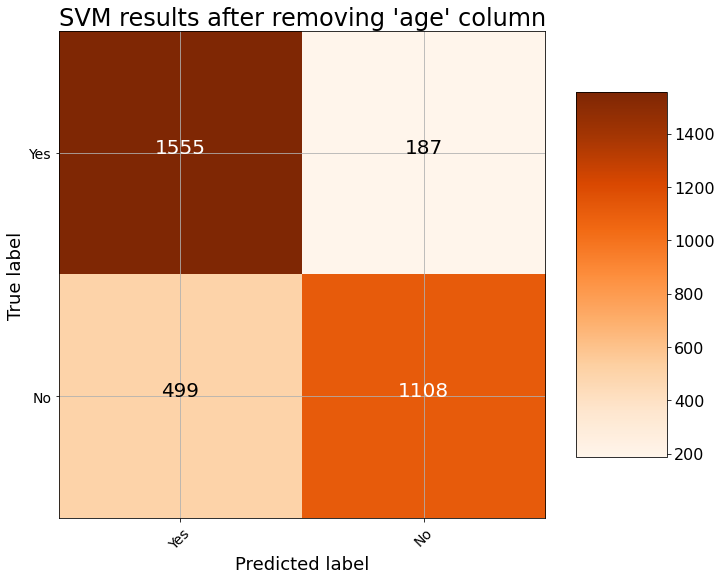

In [275]:
cf = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cf, title="SVM results after removing 'age' column")

In [276]:
#Calculating the accuracy after dropping job column
print(f"Accuracy: {accuracy_score(y_test, y_pred)*100}%")

Accuracy: 79.51627351448194%


### Observation after removing age column and checking accuracy

As we see slight increase in the accuracy from 78.59% to 78.73%, we can conclude that the education feature is relevant to our dataset.